In [1]:
import time
import re, ast
import numpy as np
import os
import pandas as pd
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils

os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("KafkaReceive") \
    .getOrCreate()

In [3]:
from sklearn.cluster import KMeans
locs = pd.read_csv("../../data/mote_locs.txt", header=None, sep=" ")
locs.columns = ["SensorId", "X", "Y"]
ids = locs.values[:, 0]
pos = locs.values[:, 1:]

kmeans = KMeans(n_clusters=5, random_state=0).fit(pos)
labels = np.vstack((ids, kmeans.labels_)).T.astype(int)
clusters = pd.DataFrame({'SensorId': labels[:,0], 'ClusterId': labels[:,1]})

clusters.loc[clusters.SensorId==1].ClusterId

0    2
Name: ClusterId, dtype: int64

In [4]:
# sensor to predict
sensors_to_predict = [1, 24]
target_cluster = clusters[clusters.SensorId.isin(sensors_to_predict)]
print(target_cluster)

    ClusterId  SensorId
0           2         1
23          4        24


In [5]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='persistence',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "zoo1:2181,zoo2:2181,zoo3:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]

In [6]:
#Save state in global Python variable
def saveState(rdd):
    global state_global
    if rdd is not None:
        data=rdd.collect()
        state_global.append(data)
        
def printInfoRDD(rdd):
    #clear_output(wait=True)
    if rdd is not None:
        print("The RDD has "+str(rdd.getNumPartitions())+" partitions")
        print("The RDD has "+str(rdd.count())+" elements")
    else:
        print("No info to provide")

In [7]:
def updateEMA(new_value, state):
    # new_value = (x, y_true, time_y, y_id) where x in avg temp in cluster
    # state = (alpha, EMA, MSSE, N, err2, y_true, y_time, y_id)
    if len(new_value) > 0:
        x = new_value[0][0]
        y_true = new_value[0][1]
        y_time = new_value[0][2]
        y_id = new_value[0][3]
        
        alpha = state[0]
        EMA = state[1]
        EMA = alpha*x + (1-alpha)*EMA # exp. moving avg
        N = state[3]
        SSE = state[2] * N
        try:
            err = y_true - EMA      
            SSE = SSE + pow(err,2)
            N += 1
        except TypeError:
            print('y_true is not valid type')
            
        return (alpha, EMA, SSE/N, N, err**2, y_true, y_time, y_id)
    else:
        return state

In [8]:
import requests

OPENTSDB_URL = 'http://' + os.environ.get('OPENTSDB_URL') #"http://localhost:4242"
print(OPENTSDB_URL)

def sendPartition(iter):
    print("Sending the partition")
    print(iter.collect())
    if iter:
        r = requests.post(OPENTSDB_URL + '/api/put', data=json.dumps(iter.collect()[0]))
        print(r.status_code)
        return r.status_code
    else:
        r = 400
        print(r)
        return r

http://opentsdb:4242


In [ ]:
def plot(rdd):
    data = rdd.collect()
    print(data)

In [51]:
import re, ast
import json

#Batch interval (to be synchronized with KafkaSend)
interval = 0.5
time_resolution = 30
simulation = 1

# state = (alpha, EMA, MSSE, N, err2, y_true, y_time, y_id)
alpha1 = 0.2
cluster1 = int(clusters.loc[clusters.SensorId==1].ClusterId)
state1 = (alpha1,20,0,0,0,20,0,1)

alpha24 = 0.2
cluster24 = int(clusters.loc[clusters.SensorId==24].ClusterId)
state24 = (alpha24,20,0,0,0,20,0,24)

state_global = []

# dstream value format: y_id, time_y, y_true, x_Value, x_seconds, x_SensorId, x_Type)
if simulation:
    [sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='EMA',batch_interval=interval)
    dstream = dstream.map(lambda x: json.loads(x[1]))
else:
    [sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='EMA',batch_interval=time_resolution)
    dstream = dstream.map(lambda x: json.loads(x[1]))\
                     .window(time_resolution, time_resolution)

# dstream value format: (ClusterId, (y_id, time_y, y_true, x_Value, x_seconds, x_SensorId, x_Type)):
dstream = dstream.map(lambda x: (int(clusters.loc[clusters.SensorId==int(x[5])].ClusterId), x))
# keep only data belonging to target_cluster_id:
dstream = dstream.filter(lambda x: x[0] == int(target_cluster[target_cluster.SensorId==x[1][0]].ClusterId))
dstream = dstream.mapValues(lambda x: (x[3], 1, x[2], x[1], x[0])) # (x, 1, y_true, time_y, y_id)
# compute average of x:
dstream = dstream.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2], x[3], x[4]))
dstream = dstream.mapValues(lambda x: (x[0]/x[1], x[2], x[3], x[4])) # (x, y_true, time_y, y_id)

initialStateRDD = sc.parallelize([(cluster1, state1),
                                  (cluster24, state24)])
dstream = dstream.updateStateByKey(updateEMA, initialRDD=initialStateRDD)

dstream.pprint()
dstream.foreachRDD(saveState)



In [ ]:
# to send data in database, if wanted:
stateStream = dstream.map(lambda x: [{'metric': 'temperature.prediction',
                                           'timestamp': x[1][-2],
                                           'value': x[1][1],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}},
                                           {'metric': 'temperature.truth',
                                           'timestamp': x[1][-2],
                                           'value': x[1][5],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}},
                                           {'metric': 'temperature.error',
                                           'timestamp': x[1][-2],
                                           'value': x[1][4],
                                           'tags': {'space': x[1][-1], 'municipality': x[0], 'city': 'Brussels'}}
                                     ])
#stateStream.foreachRDD(sendPartition)
#stateStream.pprint()

In [52]:
ssc.start()
#ssc.awaitTermination()

-------------------------------------------
Time: 2019-06-05 12:10:11
-------------------------------------------
(4, (0.2, 20, 0, 0, 0, 20, 0, 24))
(2, (0.2, 20, 0, 0, 0, 20, 0, 1))

-------------------------------------------
Time: 2019-06-05 12:10:11.500000
-------------------------------------------
(4, (0.2, 20, 0, 0, 0, 20, 0, 24))
(2, (0.2, 20, 0, 0, 0, 20, 0, 1))

-------------------------------------------
Time: 2019-06-05 12:10:12
-------------------------------------------
(4, (0.2, 20, 0, 0, 0, 20, 0, 24))
(2, (0.2, 20, 0, 0, 0, 20, 0, 1))

-------------------------------------------
Time: 2019-06-05 12:10:12.500000
-------------------------------------------
(4, (0.2, 20, 0, 0, 0, 20, 0, 24))
(2, (0.2, 20, 0, 0, 0, 20, 0, 1))

-------------------------------------------
Time: 2019-06-05 12:10:13
-------------------------------------------
(4, (0.2, 20, 0, 0, 0, 20, 0, 24))
(2, (0.2, 20, 0, 0, 0, 20, 0, 1))

-------------------------------------------
Time: 2019-06-05 12:10

-------------------------------------------
Time: 2019-06-05 12:10:27.500000
-------------------------------------------
(4, (0.2, 18.99690467506941, 0.044155279935309835, 20, 0.05846497915829076, 19.2387, 20, 24))
(2, (0.2, 18.885065493109813, 0.08744674708801296, 20, 0.12505736446346646, 19.2387, 20, 1))

-------------------------------------------
Time: 2019-06-05 12:10:28
-------------------------------------------
(4, (0.2, 18.987616873388863, 0.04517299808646717, 21, 0.06552736110961395, 19.2436, 21, 24))
(2, (0.2, 18.877618548334006, 0.08928233449236063, 21, 0.12599408257931374, 19.232575, 21, 1))

-------------------------------------------
Time: 2019-06-05 12:10:28.500000
-------------------------------------------
(4, (0.2, 18.978739498711093, 0.04585389424128621, 22, 0.060152713492486104, 19.224, 22, 24))
(2, (0.2, 18.87035432584669, 0.09098787061319423, 22, 0.12680412915069963, 19.22645, 22, 1))

-------------------------------------------
Time: 2019-06-05 12:10:29
--------

-------------------------------------------
Time: 2019-06-05 12:10:41
-------------------------------------------
(4, (0.2, 18.841052138029816, 0.05337812071263643, 47, 0.05567139356829996, 19.076999999999998, 47, 24))
(2, (0.2, 18.789275585371534, 0.12603363179387247, 47, 0.1413191655137536, 19.1652, 47, 1))

-------------------------------------------
Time: 2019-06-05 12:10:41.500000
-------------------------------------------
(4, (0.2, 18.83736011042385, 0.05336662600696434, 48, 0.052826374840375896, 19.0672, 48, 24))
(2, (0.2, 18.788369750348508, 0.12628985010245472, 48, 0.13833211060582068, 19.1603, 48, 1))

-------------------------------------------
Time: 2019-06-05 12:10:42
-------------------------------------------
(4, (0.2, 18.833446088339084, 0.05339263141940954, 49, 0.0546408912167792, 19.0672, 49, 24))
(2, (0.2, 18.787019390022397, 0.12648198119847545, 49, 0.13570427380747072, 19.1554, 49, 1))

-------------------------------------------
Time: 2019-06-05 12:10:42.500000
-

-------------------------------------------
Time: 2019-06-05 12:10:54.500000
-------------------------------------------
(4, (0.2, 18.679973486826924, 0.05176240400675629, 74, 0.04583588965389262, 18.894066666666667, 74, 24))
(2, (0.2, 18.6799059954664, 0.12974883649580518, 74, 0.1351988809699553, 19.0476, 74, 1))

-------------------------------------------
Time: 2019-06-05 12:10:55
-------------------------------------------
(4, (0.2, 18.673053856128206, 0.0516578860502072, 75, 0.04392355726557497, 18.882633333333334, 75, 24))
(2, (0.2, 18.675732232270555, 0.12967341974494226, 75, 0.12409258018108545, 19.028, 75, 1))

-------------------------------------------
Time: 2019-06-05 12:10:55.500000
-------------------------------------------
(4, (0.2, 18.6662866182359, 0.05153067036567816, 76, 0.041989494026000065, 18.8712, 76, 24))
(2, (0.2, 18.671691426842088, 0.12966071308796012, 76, 0.12870771381429974, 19.03045, 76, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:11:08
-------------------------------------------
(4, (0.2, 18.52625722006539, 0.04690252650606678, 101, 0.02218395169464997, 18.6752, 101, 24))
(2, (0.2, 18.571634517208246, 0.13111360257180785, 101, 0.15036206964472418, 18.959400000000002, 101, 1))

-------------------------------------------
Time: 2019-06-05 12:11:08.500000
-------------------------------------------
(4, (0.2, 18.521974442718978, 0.046703259896465996, 102, 0.026577332326787342, 18.685, 102, 24))
(2, (0.2, 18.566839972740954, 0.13133899249759035, 102, 0.15410337500162166, 18.9594, 102, 1))

-------------------------------------------
Time: 2019-06-05 12:11:09
-------------------------------------------
(4, (0.2, 18.518133354175184, 0.0464893440841766, 103, 0.02466993123065826, 18.6752, 103, 24))
(2, (0.2, 18.562675157679944, 0.13151735988697685, 103, 0.14971083360440018, 18.9496, 103, 1))

-------------------------------------------
Time: 2019-06-05 12:1

-------------------------------------------
Time: 2019-06-05 12:11:21.500000
-------------------------------------------
(4, (0.2, 18.357744344682214, 0.039890928633312325, 128, 0.017780714258729215, 18.2244, 128, 24))
(2, (0.2, 18.436412207301448, 0.14064699453463197, 128, 0.17784870814160267, 18.858133333333335, 128, 1))

-------------------------------------------
Time: 2019-06-05 12:11:22
-------------------------------------------
(4, (0.2, 18.348036009079102, 0.039740739684968114, 129, 0.020516554296909052, 18.2048, 129, 24))
(2, (0.2, 18.42919176584116, 0.14096135210562555, 129, 0.18119912119280404, 18.854866666666666, 129, 1))

-------------------------------------------
Time: 2019-06-05 12:11:22.500000
-------------------------------------------
(4, (0.2, 18.338087207263282, 0.03961484551927425, 130, 0.02337449814476625, 18.1852, 130, 24))
(2, (0.2, 18.421772028057546, 0.14129820390069125, 130, 0.18475208546416383, 18.8516, 130, 1))

-------------------------------------------

-------------------------------------------
Time: 2019-06-05 12:11:35
-------------------------------------------
(4, (0.2, 18.170114217036637, 0.04052336257556123, 155, 0.05983611517644738, 17.9255, 155, 24))
(2, (0.2, 18.30573468462712, 0.14945299169376708, 155, 0.19190122053274214, 18.7438, 155, 1))

-------------------------------------------
Time: 2019-06-05 12:11:35.500000
-------------------------------------------
(4, (0.2, 18.16571604029598, 0.04068014991546265, 156, 0.06498218760018239, 17.9108, 156, 24))
(2, (0.2, 18.301393593855543, 0.14970825505808483, 156, 0.18927407652733155, 18.73645, 156, 1))

-------------------------------------------
Time: 2019-06-05 12:11:36
-------------------------------------------
(4, (0.2, 18.161086832236784, 0.04082004385479807, 157, 0.0626434983911247, 17.9108, 157, 24))
(2, (0.2, 18.296817593033154, 0.14994494183716103, 157, 0.18686807937305203, 18.729100000000003, 157, 1))

-------------------------------------------
Time: 2019-06-05 12:11

-------------------------------------------
Time: 2019-06-05 12:11:48.500000
-------------------------------------------
(4, (0.2, 18.03904507825066, 0.044168575771644986, 182, 0.06535440603378544, 17.7834, 182, 24))
(2, (0.2, 18.180659223698033, 0.15910938053494453, 182, 0.2445705794253525, 18.6752, 182, 1))

-------------------------------------------
Time: 2019-06-05 12:11:49
-------------------------------------------
(4, (0.2, 18.034735562600527, 0.044279168864611224, 183, 0.06440711178446588, 17.78095, 183, 24))
(2, (0.2, 18.17744384049689, 0.1595410298959395, 183, 0.2381012135970244, 18.665399999999998, 183, 1))

-------------------------------------------
Time: 2019-06-05 12:11:49.500000
-------------------------------------------
(4, (0.2, 18.031181783413757, 0.04438552166246201, 184, 0.06384808366915631, 17.7785, 184, 24))
(2, (0.2, 18.17398702111546, 0.1599345626760161, 184, 0.23195106143003846, 18.6556, 184, 1))

-------------------------------------------
Time: 2019-06-05 

-------------------------------------------
Time: 2019-06-05 12:12:02
-------------------------------------------
(4, (0.2, 17.930789953562513, 0.046198958914358025, 209, 0.06512191239923802, 17.6756, 209, 24))
(2, (0.2, 18.060953801835794, 0.1686173399410138, 209, 0.25648775163497767, 18.5674, 209, 1))

-------------------------------------------
Time: 2019-06-05 12:12:02.500000
-------------------------------------------
(4, (0.2, 17.92762496285001, 0.046281423785716085, 210, 0.0635165818995498, 17.6756, 210, 24))
(2, (0.2, 18.05564919531479, 0.16906149016079927, 210, 0.2618888860959601, 18.5674, 210, 1))

-------------------------------------------
Time: 2019-06-05 12:12:03
-------------------------------------------
(4, (0.2, 17.92455397028001, 0.046355815518097435, 211, 0.06197807931817982, 17.6756, 211, 24))
(2, (0.2, 18.050827561380036, 0.1695249289957802, 211, 0.26684708434177595, 18.5674, 211, 1))

-------------------------------------------
Time: 2019-06-05 12:12:03.500000
--

-------------------------------------------
Time: 2019-06-05 12:12:15.500000
-------------------------------------------
(4, (0.2, 17.82369907840214, 0.047325016385635243, 236, 0.06548433832706516, 17.5678, 236, 24))
(2, (0.2, 18.00390334068824, 0.1797218976851105, 236, 0.2596887551817069, 18.5135, 236, 1))

-------------------------------------------
Time: 2019-06-05 12:12:16
-------------------------------------------
(4, (0.2, 17.821551929388377, 0.047386629323925046, 237, 0.06192728276031914, 17.572699999999998, 237, 24))
(2, (0.2, 18.000887287935207, 0.18004075215986978, 237, 0.25529040820306814, 18.506149999999998, 237, 1))

-------------------------------------------
Time: 2019-06-05 12:12:16.500000
-------------------------------------------
(4, (0.2, 17.819719876844033, 0.047433836909803385, 238, 0.05862203476296956, 17.5776, 238, 24))
(2, (0.2, 17.997909061117397, 0.1803384453552262, 238, 0.2508917326546945, 18.4988, 238, 1))

-------------------------------------------
Time:

-------------------------------------------
Time: 2019-06-05 12:12:29
-------------------------------------------
(4, (0.2, 17.757840544571934, 0.048724206239588494, 259, 0.06689493129646748, 17.4992, 261, 24))
(2, (0.2, 17.917231608893438, 0.18804480715319677, 260, 0.2836290912058317, 18.4498, 261, 1))

-------------------------------------------
Time: 2019-06-05 12:12:29.500000
-------------------------------------------
(4, (0.2, 17.75373226899088, 0.04878121110151158, 260, 0.0635454703395917, 17.501649999999998, 263, 24))
(2, (0.2, 17.916294569166034, 0.18835558978886582, 261, 0.2691590750628155, 18.4351, 263, 1))

-------------------------------------------
Time: 2019-06-05 12:12:30
-------------------------------------------
(4, (0.2, 17.75373226899088, 0.04878121110151158, 260, 0.0635454703395917, 17.501649999999998, 263, 24))
(2, (0.2, 17.916294569166034, 0.18835558978886582, 261, 0.2691590750628155, 18.4351, 263, 1))

-------------------------------------------
Time: 2019-06-0

-------------------------------------------
Time: 2019-06-05 12:12:42.500000
-------------------------------------------
(4, (0.2, 17.67738039393145, 0.04991162154614252, 274, 0.06334302068949053, 17.4257, 289, 24))
(2, (0.2, 17.854468071900058, 0.19141160878127414, 275, 0.23768738091684566, 18.342, 289, 1))

-------------------------------------------
Time: 2019-06-05 12:12:43
-------------------------------------------
(4, (0.2, 17.67738039393145, 0.04991162154614252, 274, 0.06334302068949053, 17.4257, 289, 24))
(2, (0.2, 17.854468071900058, 0.19141160878127414, 275, 0.23768738091684566, 18.342, 289, 1))

-------------------------------------------
Time: 2019-06-05 12:12:43.500000
-------------------------------------------
(4, (0.2, 17.671515081811826, 0.049941179564681644, 275, 0.058040076644399655, 17.4306, 291, 24))
(2, (0.2, 17.84840856008415, 0.19161253765553315, 276, 0.2468679780767652, 18.345266666666667, 291, 1))

-------------------------------------------
Time: 2019-06-05 

-------------------------------------------
Time: 2019-06-05 12:12:56
-------------------------------------------
(4, (0.2, 17.60001570790289, 0.050517063585583256, 288, 0.06636585295830692, 17.3424, 317, 24))
(2, (0.2, 17.792688647104228, 0.19432613679584668, 289, 0.2406013873196413, 18.2832, 317, 1))

-------------------------------------------
Time: 2019-06-05 12:12:56.500000
-------------------------------------------
(4, (0.2, 17.59446312187787, 0.05056211117667403, 289, 0.06353581741081668, 17.3424, 318, 24))
(2, (0.2, 17.78606284076031, 0.19448601947584016, 290, 0.24069211399395657, 18.276666666666667, 318, 1))

-------------------------------------------
Time: 2019-06-05 12:12:57
-------------------------------------------
(4, (0.2, 17.59446312187787, 0.05056211117667403, 289, 0.06353581741081668, 17.3424, 318, 24))
(2, (0.2, 17.78606284076031, 0.19448601947584016, 290, 0.24069211399395657, 18.276666666666667, 318, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:13:09.500000
-------------------------------------------
(4, (0.2, 17.50912765097757, 0.051220037609903096, 303, 0.06251382625336237, 17.2591, 343, 24))
(2, (0.2, 17.680075870165723, 0.19791858254296413, 304, 0.2753354124303379, 18.2048, 343, 1))

-------------------------------------------
Time: 2019-06-05 12:13:10
-------------------------------------------
(4, (0.2, 17.50912765097757, 0.051220037609903096, 303, 0.06251382625336237, 17.2591, 343, 24))
(2, (0.2, 17.680075870165723, 0.19791858254296413, 304, 0.2753354124303379, 18.2048, 343, 1))

-------------------------------------------
Time: 2019-06-05 12:13:10.500000
-------------------------------------------
(4, (0.2, 17.50454512078206, 0.051245782975409625, 304, 0.05904662872388727, 17.26155, 345, 24))
(2, (0.2, 17.678359632030016, 0.19821246827967762, 305, 0.2875537322405806, 18.214599999999997, 345, 1))

-------------------------------------------
Time: 2019-06-0

-------------------------------------------
Time: 2019-06-05 12:13:23
-------------------------------------------
(4, (0.2, 17.43617129749434, 0.051787603869383025, 320, 0.060354386412552516, 17.1905, 370, 24))
(2, (0.2, 17.617414999084538, 0.20140248021987855, 319, 0.2624017709406703, 18.129666666666665, 369, 1))

-------------------------------------------
Time: 2019-06-05 12:13:23.500000
-------------------------------------------
(4, (0.2, 17.433352149106582, 0.0518174902354813, 321, 0.061381127386929794, 17.1856, 371, 24))
(2, (0.2, 17.61163689670353, 0.201632992623379, 320, 0.2751664493400218, 18.1362, 371, 1))

-------------------------------------------
Time: 2019-06-05 12:13:24
-------------------------------------------
(4, (0.2, 17.43046519296948, 0.05184277431154496, 322, 0.059958962727979515, 17.1856, 372, 24))
(2, (0.2, 17.61163689670353, 0.201632992623379, 320, 0.2751664493400218, 18.1362, 371, 1))

-------------------------------------------
Time: 2019-06-05 12:13:24.50

-------------------------------------------
Time: 2019-06-05 12:13:36.500000
-------------------------------------------
(4, (0.2, 17.364402741441346, 0.05313783703421337, 347, 0.07129046393719395, 17.0974, 397, 24))
(2, (0.2, 17.547632154915668, 0.20746628048613075, 342, 0.28761895397217757, 18.083933333333334, 397, 1))

-------------------------------------------
Time: 2019-06-05 12:13:37
-------------------------------------------
(4, (0.2, 17.361269659819744, 0.053190204792530726, 348, 0.07136181692865487, 17.094133333333332, 398, 24))
(2, (0.2, 17.54293115982997, 0.20769424159582922, 343, 0.2856569411126989, 18.0774, 398, 1))

-------------------------------------------
Time: 2019-06-05 12:13:37.500000
-------------------------------------------
(4, (0.2, 17.357711327855796, 0.0532418261919938, 349, 0.071206073205143, 17.090866666666663, 399, 24))
(2, (0.2, 17.538391389402438, 0.2079197583583834, 344, 0.28527200791445584, 18.072499999999998, 399, 1))

-----------------------------

-------------------------------------------
Time: 2019-06-05 12:13:50
-------------------------------------------
(4, (0.2, 17.289058386878686, 0.055107195913167394, 374, 0.07293153232351714, 17.019000000000002, 424, 24))
(2, (0.2, 17.495376768139796, 0.21432357167638025, 369, 0.30539243639161534, 18.048, 424, 1))

-------------------------------------------
Time: 2019-06-05 12:13:50.500000
-------------------------------------------
(4, (0.2, 17.286961042836282, 0.05516597991584561, 375, 0.07715119691749889, 17.0092, 425, 24))
(2, (0.2, 17.49592279912722, 0.21456807347110227, 370, 0.30478923572352035, 18.048, 425, 1))

-------------------------------------------
Time: 2019-06-05 12:13:51
-------------------------------------------
(4, (0.2, 17.28515016760236, 0.055207655266374646, 376, 0.07083591171476343, 17.019000000000002, 426, 24))
(2, (0.2, 17.496708905968447, 0.21480891928481494, 371, 0.3039218703585049, 18.048, 426, 1))

-------------------------------------------
Time: 2019-06

-------------------------------------------
Time: 2019-06-05 12:14:03.500000
-------------------------------------------
(4, (0.2, 17.23554125853897, 0.056324280697782794, 401, 0.0813055373211883, 16.9504, 451, 24))
(2, (0.2, 17.471398307441174, 0.22194407064871258, 396, 0.36328951143722116, 18.074133333333332, 451, 1))

-------------------------------------------
Time: 2019-06-05 12:14:04
-------------------------------------------
(4, (0.2, 17.23387756238673, 0.056384069871113496, 402, 0.0803595283767237, 16.9504, 452, 24))
(2, (0.2, 17.472140312619608, 0.22227814664026532, 397, 0.35457223929515275, 18.0676, 452, 1))

-------------------------------------------
Time: 2019-06-05 12:14:04.500000
-------------------------------------------
(4, (0.2, 17.232629827687163, 0.056441810828347275, 403, 0.0796536756363264, 16.9504, 453, 24))
(2, (0.2, 17.47242609624953, 0.22260968892434901, 398, 0.3542319757055705, 18.0676, 453, 1))

-------------------------------------------
Time: 2019-06-05 

-------------------------------------------
Time: 2019-06-05 12:14:17
-------------------------------------------
(4, (0.2, 17.15884645985351, 0.05862922286629192, 426, 0.11279284459613532, 16.823, 478, 24))
(2, (0.2, 17.422748788182542, 0.2282168761433481, 421, 0.32086697536946723, 17.9892, 478, 1))

-------------------------------------------
Time: 2019-06-05 12:14:17.500000
-------------------------------------------
(4, (0.2, 17.153093767882808, 0.05875217358398916, 427, 0.11112917932301566, 16.819733333333332, 479, 24))
(2, (0.2, 17.416868517725522, 0.22840004016077461, 422, 0.3055120914973413, 17.9696, 479, 1))

-------------------------------------------
Time: 2019-06-05 12:14:18
-------------------------------------------
(4, (0.2, 17.147766414306247, 0.05887134963352669, 428, 0.10975952278605176, 16.816466666666663, 480, 24))
(2, (0.2, 17.411322506488112, 0.22857126361403304, 423, 0.3008275608890845, 17.9598, 480, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:14:30.500000
-------------------------------------------
(4, (0.2, 17.03551524155377, 0.061767307933968965, 453, 0.11114349672870091, 16.702133333333332, 505, 24))
(2, (0.2, 17.313907850788127, 0.23271952566624612, 448, 0.2895431610434534, 17.852, 505, 1))

-------------------------------------------
Time: 2019-06-05 12:14:31
-------------------------------------------
(4, (0.2, 17.030840193243016, 0.06187400201858035, 454, 0.11020642234753748, 16.698866666666667, 506, 24))
(2, (0.2, 17.31221858832281, 0.2328384089599912, 449, 0.28609812455778033, 17.847099999999998, 506, 1))

-------------------------------------------
Time: 2019-06-05 12:14:31.500000
-------------------------------------------
(4, (0.2, 17.027038904594413, 0.0619794476129983, 455, 0.10985174747874503, 16.6956, 507, 24))
(2, (0.2, 17.310641024504402, 0.23294889014992437, 450, 0.28255494442992746, 17.8422, 507, 1))

----------------------------------------

-------------------------------------------
Time: 2019-06-05 12:14:44
-------------------------------------------
(4, (0.2, 16.92412600478917, 0.06567243287799832, 479, 0.16396506935451718, 16.5192, 532, 24))
(2, (0.2, 17.193009977524042, 0.23611171902044456, 473, 0.32954108234938967, 17.767066666666665, 532, 1))

-------------------------------------------
Time: 2019-06-05 12:14:44.500000
-------------------------------------------
(4, (0.2, 16.920201470498004, 0.0658706198497974, 480, 0.1608021793415602, 16.5192, 533, 24))
(2, (0.2, 17.187582853814106, 0.23633004476381891, 474, 0.3395981213798889, 17.770333333333333, 533, 1))

-------------------------------------------
Time: 2019-06-05 12:14:45
-------------------------------------------
(4, (0.2, 16.916310509731737, 0.06606152657971341, 481, 0.15769675693939886, 16.5192, 534, 24))
(2, (0.2, 17.182776283051286, 0.23656739764749318, 475, 0.3490726645090921, 17.7736, 534, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:14:57.500000
-------------------------------------------
(4, (0.2, 16.821714960302632, 0.06980085803642563, 506, 0.1305485005384927, 16.4604, 559, 24))
(2, (0.2, 17.14926248976765, 0.24184608304759575, 500, 0.3897973266831268, 17.7736, 559, 1))

-------------------------------------------
Time: 2019-06-05 12:14:58
-------------------------------------------
(4, (0.2, 16.819672234908776, 0.06991777259409807, 507, 0.1290765387763466, 16.4604, 560, 24))
(2, (0.2, 17.148644761044892, 0.24214293527843375, 501, 0.39056905069743403, 17.7736, 560, 1))

-------------------------------------------
Time: 2019-06-05 12:14:58.500000
-------------------------------------------
(4, (0.2, 16.818129521260353, 0.07003204944013558, 508, 0.1279704103811614, 16.4604, 561, 24))
(2, (0.2, 17.146720783194887, 0.24244340264334163, 502, 0.39297755246218985, 17.7736, 561, 1))

-------------------------------------------
Time: 2019-06-05 12:14:59
---

-------------------------------------------
Time: 2019-06-05 12:15:11
-------------------------------------------
(4, (0.2, 16.762911260263536, 0.07268509461920267, 533, 0.16040926959788507, 16.3624, 586, 24))
(2, (0.2, 17.093147194910724, 0.24887698097372676, 527, 0.3449833176462434, 17.680500000000002, 586, 1))

-------------------------------------------
Time: 2019-06-05 12:15:11.500000
-------------------------------------------
(4, (0.2, 16.76020940821083, 0.07283091148482236, 534, 0.15055130086011909, 16.3722, 587, 24))
(2, (0.2, 17.09133416618499, 0.24905215063961658, 528, 0.3413665645635491, 17.6756, 587, 1))

-------------------------------------------
Time: 2019-06-05 12:15:12
-------------------------------------------
(4, (0.2, 16.757100593235332, 0.0729859725069074, 535, 0.1557885583003225, 16.3624, 588, 24))
(2, (0.2, 17.089054512435172, 0.2492317034909267, 529, 0.34403560898266045, 17.6756, 588, 1))

-------------------------------------------
Time: 2019-06-05 12:15:12.5

-------------------------------------------
Time: 2019-06-05 12:15:24.500000
-------------------------------------------
(4, (0.2, 16.67014074579246, 0.07681266209847111, 560, 0.14910467556115442, 16.284000000000002, 613, 24))
(2, (0.2, 16.973030406477278, 0.25239840906851907, 554, 0.3364807333296165, 17.5531, 613, 1))

-------------------------------------------
Time: 2019-06-05 12:15:25
-------------------------------------------
(4, (0.2, 16.668156996633968, 0.07693880102175872, 561, 0.1475765980628286, 16.284000000000002, 614, 24))
(2, (0.2, 16.969620735438234, 0.2525674032124789, 555, 0.34619015896624467, 17.558, 614, 1))

-------------------------------------------
Time: 2019-06-05 12:15:25.500000
-------------------------------------------
(4, (0.2, 16.665746797307175, 0.07708851712618393, 562, 0.16107925170872817, 16.2644, 615, 24))
(2, (0.2, 16.965742485786485, 0.25276507559954453, 556, 0.36247325042095435, 17.5678, 615, 1))

-------------------------------------------
Time: 2

-------------------------------------------
Time: 2019-06-05 12:15:38
-------------------------------------------
(4, (0.2, 16.579263138483498, 0.08099561071167088, 587, 0.1396241410613372, 16.2056, 640, 24))
(2, (0.2, 16.90961205228004, 0.2566606631643907, 581, 0.34761394809663343, 17.4992, 640, 1))

-------------------------------------------
Time: 2019-06-05 12:15:38.500000
-------------------------------------------
(4, (0.2, 16.5763155107868, 0.08109158754708967, 588, 0.13742998993791677, 16.2056, 641, 24))
(2, (0.2, 16.90667553925993, 0.25684302414865434, 582, 0.3627947560058177, 17.509, 641, 1))

-------------------------------------------
Time: 2019-06-05 12:15:39
-------------------------------------------
(4, (0.2, 16.57332040862944, 0.08118655281683125, 589, 0.1370261314248849, 16.20315, 642, 24))
(2, (0.2, 16.90487286730538, 0.25704896497217056, 583, 0.37690652425863763, 17.5188, 642, 1))

-------------------------------------------
Time: 2019-06-05 12:15:39.500000
--------

-------------------------------------------
Time: 2019-06-05 12:15:51.500000
-------------------------------------------
(4, (0.2, 16.584278834577756, 0.08233052346309354, 614, 0.07878060817992744, 16.3036, 667, 24))
(2, (0.2, 16.90767908676476, 0.264192183953631, 608, 0.41656815524141344, 17.5531, 667, 1))

-------------------------------------------
Time: 2019-06-05 12:15:52
-------------------------------------------
(4, (0.2, 16.58397040099554, 0.08233356141130625, 615, 0.0841988616139118, 16.2938, 668, 24))
(2, (0.2, 16.909328089924628, 0.2644285799035977, 609, 0.4081573174833558, 17.5482, 668, 1))

-------------------------------------------
Time: 2019-06-05 12:15:52.500000
-------------------------------------------
(4, (0.2, 16.583880454129766, 0.08233650476919072, 616, 0.08414666986813045, 16.2938, 669, 24))
(2, (0.2, 16.910793036042268, 0.2646611357360538, 610, 0.4062876377018154, 17.5482, 669, 1))

-------------------------------------------
Time: 2019-06-05 12:15:53
-------

-------------------------------------------
Time: 2019-06-05 12:16:05
-------------------------------------------
(4, (0.2, 16.567081681305037, 0.08251616271837478, 641, 0.10386548210480064, 16.2448, 694, 24))
(2, (0.2, 16.876030466591004, 0.2692203591165749, 635, 0.3822572159417763, 17.4943, 694, 1))

-------------------------------------------
Time: 2019-06-05 12:16:05.500000
-------------------------------------------
(4, (0.2, 16.565175478377363, 0.08253787761720804, 642, 0.09645712776932766, 16.2546, 695, 24))
(2, (0.2, 16.87484745019588, 0.2693908850243644, 636, 0.3776748364707457, 17.4894, 695, 1))

-------------------------------------------
Time: 2019-06-05 12:16:06
-------------------------------------------
(4, (0.2, 16.56379588270189, 0.08254891963425569, 643, 0.08963789457884434, 16.2644, 696, 24))
(2, (0.2, 16.873561806310548, 0.26956335880110277, 637, 0.3792566808066872, 17.4894, 696, 1))

-------------------------------------------
Time: 2019-06-05 12:16:06.500000
-----

-------------------------------------------
Time: 2019-06-05 12:16:18.500000
-------------------------------------------
(4, (0.2, 16.52587380165662, 0.08292870565123704, 668, 0.08651861510544123, 16.231733333333334, 721, 24))
(2, (0.2, 16.835498017631988, 0.27355622914091277, 662, 0.37185845769995707, 17.4453, 721, 1))

-------------------------------------------
Time: 2019-06-05 12:16:19
-------------------------------------------
(4, (0.2, 16.52612337465863, 0.08294010501112449, 669, 0.09055487741593844, 16.2252, 722, 24))
(2, (0.2, 16.835465106413285, 0.27369558056827004, 663, 0.3659462254787712, 17.4404, 722, 1))

-------------------------------------------
Time: 2019-06-05 12:16:19.500000
-------------------------------------------
(4, (0.2, 16.526698699726907, 0.08295198763937209, 670, 0.09090146593701517, 16.2252, 723, 24))
(2, (0.2, 16.83456772615627, 0.27381841022323244, 664, 0.3552544714633261, 17.4306, 723, 1))

-------------------------------------------
Time: 2019-06-05 1

-------------------------------------------
Time: 2019-06-05 12:16:32
-------------------------------------------
(4, (0.2, 16.47993964314983, 0.08360703540426145, 695, 0.10244671027479221, 16.159866666666666, 748, 24))
(2, (0.2, 16.78823655682232, 0.27714333520465145, 689, 0.375724182672237, 17.4012, 748, 1))

-------------------------------------------
Time: 2019-06-05 12:16:32.500000
-------------------------------------------
(4, (0.2, 16.477854514519866, 0.08363519262796136, 696, 0.10320446309939392, 16.1566, 749, 24))
(2, (0.2, 16.786859245457855, 0.27727134417377863, 690, 0.3654695239023874, 17.3914, 749, 1))

-------------------------------------------
Time: 2019-06-05 12:16:33
-------------------------------------------
(4, (0.2, 16.475373011615893, 0.08366099039023783, 697, 0.1016162329346659, 16.1566, 750, 24))
(2, (0.2, 16.785493550212436, 0.27739708707192107, 691, 0.36415968679021193, 17.38895, 750, 1))

-------------------------------------------
Time: 2019-06-05 12:16:33

-------------------------------------------
Time: 2019-06-05 12:16:45.500000
-------------------------------------------
(4, (0.2, 16.441775204378008, 0.08439227112805978, 721, 0.11167306722108221, 16.1076, 775, 24))
(2, (0.2, 16.765993333865456, 0.2798826397464668, 715, 0.37296263206116875, 17.3767, 775, 1))

-------------------------------------------
Time: 2019-06-05 12:16:46
-------------------------------------------
(4, (0.2, 16.439556463502406, 0.08442800910940737, 722, 0.11019509366102549, 16.107599999999998, 776, 24))
(2, (0.2, 16.76415928247698, 0.28002842446982534, 716, 0.38426450167120507, 17.384050000000002, 776, 1))

-------------------------------------------
Time: 2019-06-05 12:16:46.500000
-------------------------------------------
(4, (0.2, 16.437796170801924, 0.08445759360405328, 723, 0.10581759873839651, 16.112499999999997, 777, 24))
(2, (0.2, 16.76210511828928, 0.28019018684594454, 717, 0.3960120481473094, 17.3914, 777, 1))

---------------------------------------

-------------------------------------------
Time: 2019-06-05 12:16:59
-------------------------------------------
(4, (0.2, 16.42924456116344, 0.08510790721882484, 748, 0.11644785052362801, 16.088, 802, 24))
(2, (0.2, 16.762236177513067, 0.2855058624239608, 742, 0.4272763928282294, 17.4159, 802, 1))

-------------------------------------------
Time: 2019-06-05 12:16:59.500000
-------------------------------------------
(4, (0.2, 16.430144448930754, 0.08513317693086385, 749, 0.10403492153604296, 16.1076, 803, 24))
(2, (0.2, 16.7637747881643, 0.28569827540582593, 743, 0.4284687079497498, 17.41835, 803, 1))

-------------------------------------------
Time: 2019-06-05 12:17:00
-------------------------------------------
(4, (0.2, 16.43130862581127, 0.08517235989232065, 750, 0.11452039802347137, 16.0929, 804, 24))
(2, (0.2, 16.765681625403236, 0.28589112730008465, 744, 0.4291800847343062, 17.4208, 804, 1))

-------------------------------------------
Time: 2019-06-05 12:17:00.500000
------

-------------------------------------------
Time: 2019-06-05 12:17:12.500000
-------------------------------------------
(4, (0.2, 16.416162961005007, 0.08589311220242442, 775, 0.09980099893095169, 16.10025, 829, 24))
(2, (0.2, 16.737200282958533, 0.28934357300635516, 769, 0.38225332122353567, 17.35546666666667, 829, 1))

-------------------------------------------
Time: 2019-06-05 12:17:13
-------------------------------------------
(4, (0.2, 16.414700768804007, 0.0859088561071157, 776, 0.09811038224286082, 16.101475, 830, 24))
(2, (0.2, 16.73582314944375, 0.2894559892720471, 770, 0.3759040975891209, 17.348933333333335, 830, 1))

-------------------------------------------
Time: 2019-06-05 12:17:13.500000
-------------------------------------------
(4, (0.2, 16.414373815043206, 0.08592331133346894, 777, 0.09714056698358721, 16.1027, 831, 24))
(2, (0.2, 16.734911160580644, 0.2895592145648448, 771, 0.3690426900190775, 17.3424, 831, 1))

-------------------------------------------
Time: 

-------------------------------------------
Time: 2019-06-05 12:17:25.500000
-------------------------------------------
(4, (0.2, 20.246693477108, 0.23684142665558555, 801, 12.595447299529965, 23.7957, 855, 24))
(2, (0.2, 19.693511939143203, 0.311664400565963, 795, 0.31302689024129887, 20.253, 855, 1))

-------------------------------------------
Time: 2019-06-05 12:17:26
-------------------------------------------
(4, (0.2, 20.4779187816864, 0.2509692471380169, 802, 11.56735345356552, 23.879, 856, 24))
(2, (0.2, 19.889538782083793, 0.3115181404344711, 796, 0.19524133589839232, 20.3314, 856, 1))

-------------------------------------------
Time: 2019-06-05 12:17:26.500000
-------------------------------------------
(4, (0.2, 20.68266422534912, 0.26519564497586995, 803, 11.674766710934062, 24.0995, 857, 24))
(2, (0.2, 20.062191025667033, 0.3112391557156728, 797, 0.08916731955218705, 20.3608, 857, 1))

-------------------------------------------
Time: 2019-06-05 12:17:27
---------------

-------------------------------------------
Time: 2019-06-05 12:17:39
-------------------------------------------
(4, (0.2, 22.844001037775353, 0.5207596949007226, 828, 7.137441014959806, 25.5156, 882, 24))
(2, (0.2, 21.87874071832186, 0.303518192495246, 822, 0.1342788000442444, 21.512299999999996, 882, 1))

-------------------------------------------
Time: 2019-06-05 12:17:39.500000
-------------------------------------------
(4, (0.2, 22.894978296886947, 0.5286812038588599, 829, 7.087690621196474, 25.55725, 883, 24))
(2, (0.2, 21.913306061836977, 0.3033149822953623, 823, 0.13627619799098706, 21.54415, 883, 1))

-------------------------------------------
Time: 2019-06-05 12:17:40
-------------------------------------------
(4, (0.2, 22.94217583750956, 0.5365480738247654, 830, 7.058183275560536, 25.5989, 884, 24))
(2, (0.2, 21.946528541777276, 0.3031134973657218, 824, 0.13729140027159434, 21.576, 884, 1))

-------------------------------------------
Time: 2019-06-05 12:17:40.500000
--

-------------------------------------------
Time: 2019-06-05 12:17:52.500000
-------------------------------------------
(4, (0.2, 23.92781084057543, 0.7074579074016759, 854, 6.568400843495986, 26.4907, 909, 24))
(2, (0.2, 22.606153635654948, 0.299902322895125, 848, 0.24123189381707164, 22.115000000000002, 909, 1))

-------------------------------------------
Time: 2019-06-05 12:17:53
-------------------------------------------
(4, (0.2, 23.96122093912701, 0.7142594876776713, 855, 6.522809043377681, 26.5152, 910, 24))
(2, (0.2, 22.627621113652168, 0.2998353823716994, 849, 0.2430698185068216, 22.134600000000002, 910, 1))

-------------------------------------------
Time: 2019-06-05 12:17:53.500000
-------------------------------------------
(4, (0.2, 23.991842884634945, 0.7210086890709407, 856, 6.491575880316338, 26.5397, 911, 24))
(2, (0.2, 22.650883660152505, 0.2997728638727474, 850, 0.24669465826248652, 22.154200000000003, 911, 1))

-------------------------------------------
Time: 2

-------------------------------------------
Time: 2019-06-05 12:18:06
-------------------------------------------
(4, (0.2, 24.60738006960751, 0.81503816431585, 870, 6.501071723440692, 27.1571, 934, 24))
(2, (0.2, 23.16867803377488, 0.30039223410072674, 864, 0.37537437307025795, 22.555999999999997, 934, 1))

-------------------------------------------
Time: 2019-06-05 12:18:06.500000
-------------------------------------------
(4, (0.2, 24.655319389019343, 0.8214013354078287, 871, 6.357360185429191, 27.1767, 936, 24))
(2, (0.2, 23.20612940137888, 0.3005238221524064, 865, 0.4142158988036878, 22.562533333333334, 936, 1))

-------------------------------------------
Time: 2019-06-05 12:18:07
-------------------------------------------
(4, (0.2, 24.655319389019343, 0.8214013354078287, 871, 6.357360185429191, 27.1767, 936, 24))
(2, (0.2, 23.20612940137888, 0.3005238221524064, 865, 0.4142158988036878, 22.562533333333334, 936, 1))

-------------------------------------------
Time: 2019-06-05 

-------------------------------------------
Time: 2019-06-05 12:18:19.500000
-------------------------------------------
(4, (0.2, 25.454770144869276, 0.9280155515684634, 887, 6.666103586329859, 28.03665, 962, 24))
(2, (0.2, 23.819723294330803, 0.3048380656077808, 881, 0.6450070258967611, 23.0166, 962, 1))

-------------------------------------------
Time: 2019-06-05 12:18:20
-------------------------------------------
(4, (0.2, 25.494323849228756, 0.9344895574200243, 888, 6.676932747754585, 28.078300000000002, 963, 24))
(2, (0.2, 23.852384789310797, 0.30524772495550706, 882, 0.6661576103023086, 23.0362, 963, 1))

-------------------------------------------
Time: 2019-06-05 12:18:20.500000
-------------------------------------------
(4, (0.2, 25.53550711271634, 0.9409517120659311, 889, 6.679345037631124, 28.119950000000003, 964, 24))
(2, (0.2, 23.883451677602487, 0.3056916435021021, 883, 0.6972278015989634, 23.048450000000003, 964, 1))

-------------------------------------------
Time:

-------------------------------------------
Time: 2019-06-05 12:18:33
-------------------------------------------
(4, (0.2, 26.277476796875472, 1.0410128902242597, 904, 7.014675157488999, 28.926, 990, 24))
(2, (0.2, 24.439654345729632, 0.31391836715802335, 898, 0.8165911765560541, 23.535999999999998, 990, 1))

-------------------------------------------
Time: 2019-06-05 12:18:33.500000
-------------------------------------------
(4, (0.2, 26.324038170833713, 1.0475135003742808, 905, 6.924065075993333, 28.955399999999997, 991, 24))
(2, (0.2, 24.476898091968323, 0.31449335092276626, 899, 0.8308287716618993, 23.565399999999997, 991, 1))

-------------------------------------------
Time: 2019-06-05 12:18:34
-------------------------------------------
(4, (0.2, 26.324038170833713, 1.0475135003742808, 905, 6.924065075993333, 28.955399999999997, 991, 24))
(2, (0.2, 24.476898091968323, 0.31449335092276626, 899, 0.8308287716618993, 23.565399999999997, 991, 1))

---------------------------------

-------------------------------------------
Time: 2019-06-05 12:18:46.500000
-------------------------------------------
(4, (0.2, 27.10546110949153, 1.1552614756856971, 922, 6.886104916679037, 29.7296, 1016, 24))
(2, (0.2, 25.046355607814274, 0.3241027532177338, 913, 1.0713401112677787, 24.0113, 1016, 1))

-------------------------------------------
Time: 2019-06-05 12:18:47
-------------------------------------------
(4, (0.2, 27.136809887593223, 1.161376040377586, 923, 6.799004686299119, 29.744300000000003, 1017, 24))
(2, (0.2, 25.046355607814274, 0.3241027532177338, 913, 1.0713401112677787, 24.0113, 1016, 1))

-------------------------------------------
Time: 2019-06-05 12:18:47.500000
-------------------------------------------
(4, (0.2, 27.16595591007458, 1.1673960637671095, 924, 6.723877652297154, 29.759, 1018, 24))
(2, (0.2, 25.086844742661675, 0.3249567929309275, 914, 1.104695051076751, 24.0358, 1018, 1))

-------------------------------------------
Time: 2019-06-05 12:18:48
-

-------------------------------------------
Time: 2019-06-05 12:19:00
-------------------------------------------
(4, (0.2, 27.942611157713003, 1.3012681414096745, 946, 6.864341533708358, 30.5626, 1043, 24))
(2, (0.2, 25.73320370811328, 0.3490956920100525, 936, 2.102365755671453, 24.28325, 1043, 1))

-------------------------------------------
Time: 2019-06-05 12:19:00.500000
-------------------------------------------
(4, (0.2, 27.976167926170405, 1.3070117030145023, 947, 6.740420981181512, 30.5724, 1044, 24))
(2, (0.2, 25.74443481264447, 0.3511334900699097, 937, 2.258512474096147, 24.2416, 1044, 1))

-------------------------------------------
Time: 2019-06-05 12:19:01
-------------------------------------------
(4, (0.2, 28.011612840936326, 1.31276372993885, 948, 6.759933227295989, 30.6116, 1045, 24))
(2, (0.2, 25.75161926037199, 0.3535157847944911, 938, 2.5857259417272798, 24.1436, 1045, 1))

-------------------------------------------
Time: 2019-06-05 12:19:01.500000
-------------

-------------------------------------------
Time: 2019-06-05 12:19:13.500000
-------------------------------------------
(4, (0.2, 28.66486917779985, 1.4319150398580085, 971, 6.1788577204358335, 31.1506, 1070, 24))
(2, (0.2, 25.296994505702582, 0.40518811120400283, 961, 1.0932678703554333, 24.251399999999997, 1070, 1))

-------------------------------------------
Time: 2019-06-05 12:19:14
-------------------------------------------
(4, (0.2, 28.703571342239883, 1.4369272243775968, 972, 6.303758392897927, 31.2143, 1071, 24))
(2, (0.2, 25.28150601481848, 0.405891038863516, 962, 1.0814045196556545, 24.2416, 1071, 1))

-------------------------------------------
Time: 2019-06-05 12:19:14.500000
-------------------------------------------
(4, (0.2, 28.73994757379191, 1.4420708861389566, 973, 6.441710118180788, 31.278000000000002, 1072, 24))
(2, (0.2, 25.27012537595735, 0.40658909550681144, 963, 1.0781195863569706, 24.2318, 1072, 1))

-------------------------------------------
Time: 2019-06

-------------------------------------------
Time: 2019-06-05 12:19:27
-------------------------------------------
(4, (0.2, 28.838817942241704, 1.5101737706730125, 997, 3.142756224309736, 30.6116, 1097, 24))
(2, (0.2, 25.53908183280026, 0.41285148770949837, 987, 0.3108975002689008, 24.981499999999997, 1097, 1))

-------------------------------------------
Time: 2019-06-05 12:19:27.500000
-------------------------------------------
(4, (0.2, 28.838817942241704, 1.5101737706730125, 997, 3.142756224309736, 30.6116, 1097, 24))
(2, (0.2, 25.53908183280026, 0.41285148770949837, 987, 0.3108975002689008, 24.981499999999997, 1097, 1))

-------------------------------------------
Time: 2019-06-05 12:19:28
-------------------------------------------
(4, (0.2, 28.817941953793365, 1.5116423593424606, 998, 2.975825262782249, 30.543, 1099, 24))
(2, (0.2, 25.54552228675303, 0.41272824156596977, 988, 0.29108429790321877, 25.006, 1099, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:19:40.500000
-------------------------------------------
(4, (0.2, 28.68861588940822, 1.5631943291621506, 1021, 4.490093660940446, 30.8076, 1124, 24))
(2, (0.2, 25.768113746433876, 0.41091316315250065, 1011, 0.5513266636432747, 25.025599999999997, 1124, 1))

-------------------------------------------
Time: 2019-06-05 12:19:41
-------------------------------------------
(4, (0.2, 28.69423426708213, 1.566260715099448, 1022, 4.697040757080028, 30.8615, 1125, 24))
(2, (0.2, 25.780305868941973, 0.411084661235993, 1012, 0.5844692236467229, 25.0158, 1125, 1))

-------------------------------------------
Time: 2019-06-05 12:19:41.500000
-------------------------------------------
(4, (0.2, 28.70431185811015, 1.5695086623683694, 1023, 4.888910771205922, 30.9154, 1126, 24))
(2, (0.2, 25.7936466182305, 0.4112611774714711, 1013, 0.5898956077753069, 25.0256, 1126, 1))

-------------------------------------------
Time: 2019-06-05 12:19

-------------------------------------------
Time: 2019-06-05 12:19:54
-------------------------------------------
(4, (0.2, 29.006040566927577, 1.6535517822475652, 1048, 6.401032065361006, 31.53606666666667, 1151, 24))
(2, (0.2, 25.98600791898893, 0.4147705433999241, 1038, 0.3457533127936863, 25.398000000000003, 1151, 1))

-------------------------------------------
Time: 2019-06-05 12:19:54.500000
-------------------------------------------
(4, (0.2, 29.028781653542065, 1.6585763873303372, 1049, 6.924362514075428, 31.660200000000003, 1152, 24))
(2, (0.2, 25.987741976216785, 0.41480099879644283, 1039, 0.44641370038286976, 25.3196, 1152, 1))

-------------------------------------------
Time: 2019-06-05 12:19:55
-------------------------------------------
(4, (0.2, 29.052808789500318, 1.663459380018746, 1050, 6.785718710159548, 31.65775, 1153, 24))
(2, (0.2, 25.994391786101634, 0.41486578625202836, 1040, 0.4821799526054162, 25.3, 1153, 1))

-------------------------------------------
Tim

-------------------------------------------
Time: 2019-06-05 12:20:07
-------------------------------------------
(4, (0.2, 29.7258041905704, 1.7646035861248146, 1074, 6.815210480211373, 32.3364, 1177, 24))
(2, (0.2, 26.310268005686044, 0.4136828364705679, 1064, 0.419473845589341, 25.662599999999998, 1177, 1))

-------------------------------------------
Time: 2019-06-05 12:20:07.500000
-------------------------------------------
(4, (0.2, 29.742531908011877, 1.7694917017772522, 1075, 7.01932791249537, 32.391933333333334, 1178, 24))
(2, (0.2, 26.316677994292426, 0.41363447406454734, 1065, 0.3621768740586809, 25.714866666666666, 1178, 1))

-------------------------------------------
Time: 2019-06-05 12:20:08
-------------------------------------------
(4, (0.2, 29.75663819307617, 1.774576335766572, 1076, 7.24055787428538, 32.44746666666667, 1179, 24))
(2, (0.2, 26.321780856972406, 0.41353503635480476, 1066, 0.30763387547895565, 25.767133333333334, 1179, 1))

----------------------------

-------------------------------------------
Time: 2019-06-05 12:20:20.500000
-------------------------------------------
(4, (0.2, 29.946132032023545, 1.8989323541809113, 1101, 5.165019692666236, 32.2188, 1204, 24))
(2, (0.2, 26.47770359079137, 0.41692090316647257, 1091, 0.7637074859980533, 25.6038, 1204, 1))

-------------------------------------------
Time: 2019-06-05 12:20:21
-------------------------------------------
(4, (0.2, 29.923634292285506, 1.9016683957859186, 1102, 4.914050202898941, 32.1404, 1205, 24))
(2, (0.2, 26.46683541109464, 0.41719055736933147, 1092, 0.7113832926883822, 25.6234, 1205, 1))

-------------------------------------------
Time: 2019-06-05 12:20:21.500000
-------------------------------------------
(4, (0.2, 29.899331433828404, 1.9045376078497385, 1103, 5.066409302179366, 32.1502, 1206, 24))
(2, (0.2, 26.44966470494409, 0.41760710477615026, 1093, 0.8724768730222933, 25.5156, 1206, 1))

-------------------------------------------
Time: 2019-06-05 12:20:22
-

-------------------------------------------
Time: 2019-06-05 12:20:34
-------------------------------------------
(4, (0.2, 29.37450211138679, 1.9739337246049182, 1128, 5.081408121028266, 31.628700000000002, 1231, 24))
(2, (0.2, 25.423007454865683, 0.4419550432875474, 1118, 0.8586013754126565, 24.4964, 1231, 1))

-------------------------------------------
Time: 2019-06-05 12:20:34.500000
-------------------------------------------
(4, (0.2, 29.3646063557761, 1.9767229336962453, 1129, 5.122950788713146, 31.628, 1232, 24))
(2, (0.2, 25.37620938269597, 0.4424059795017121, 1119, 0.9465526669378475, 24.4033, 1232, 1))

-------------------------------------------
Time: 2019-06-05 12:20:35
-------------------------------------------
(4, (0.2, 29.356722417954217, 1.979536030707212, 1130, 5.155522556088885, 31.6273, 1233, 24))
(2, (0.2, 25.3284943266696, 0.4429367985697708, 1120, 1.0369233357274883, 24.310200000000002, 1233, 1))

-------------------------------------------
Time: 2019-06-05 12:

-------------------------------------------
Time: 2019-06-05 12:20:47.500000
-------------------------------------------
(4, (0.2, 28.972138151683744, 2.051380359091869, 1155, 4.918024073477465, 31.189799999999998, 1258, 24))
(2, (0.2, 24.466902263364396, 0.4434019107723336, 1145, 0.14850921223328667, 24.081533333333333, 1258, 1))

-------------------------------------------
Time: 2019-06-05 12:20:48
-------------------------------------------
(4, (0.2, 28.94544365468033, 2.0535909691282033, 1156, 4.606845561094013, 31.0918, 1259, 24))
(2, (0.2, 24.44595232351203, 0.4431688898676659, 1146, 0.17635995402315413, 24.026, 1259, 1))

-------------------------------------------
Time: 2019-06-05 12:20:48.500000
-------------------------------------------
(4, (0.2, 28.917672323744263, 2.0560501121129495, 1157, 4.898819402479622, 31.131, 1260, 24))
(2, (0.2, 24.42588801265578, 0.4429086022327069, 1147, 0.1446189725696818, 24.0456, 1260, 1))

-------------------------------------------
Time: 201

-------------------------------------------
Time: 2019-06-05 12:21:00.500000
-------------------------------------------
(4, (0.2, 28.338755862339866, 2.1172961821583423, 1181, 4.616958120630724, 30.487466666666666, 1284, 24))
(2, (0.2, 24.106191735254157, 0.4372673341633252, 1171, 0.17292434877918658, 23.690350000000002, 1284, 1))

-------------------------------------------
Time: 2019-06-05 12:21:01
-------------------------------------------
(4, (0.2, 28.323578023205226, 2.1194156632509142, 1182, 4.622522833579048, 30.47358333333333, 1285, 24))
(2, (0.2, 24.100626824100765, 0.4370294143839228, 1172, 0.15842535270374075, 23.7026, 1285, 1))

-------------------------------------------
Time: 2019-06-05 12:21:01.500000
-------------------------------------------
(4, (0.2, 28.309900418564183, 2.121530813358345, 1183, 4.621638240341604, 30.459699999999998, 1286, 24))
(2, (0.2, 24.098298228511382, 0.43678218772541005, 1173, 0.14703254394851825, 23.71485, 1286, 1))

------------------------

-------------------------------------------
Time: 2019-06-05 12:21:13.500000
-------------------------------------------
(4, (0.2, 28.078426184004556, 2.167817204747068, 1207, 5.2806836590006485, 30.376399999999997, 1310, 24))
(2, (0.2, 24.226079436602348, 0.4319963020615947, 1197, 0.3056756714177277, 23.6732, 1310, 1))

-------------------------------------------
Time: 2019-06-05 12:21:14
-------------------------------------------
(4, (0.2, 28.070335547203644, 2.170537881076148, 1208, 5.454394210275378, 30.4058, 1311, 24))
(2, (0.2, 24.229296626204956, 0.4318340789050836, 1198, 0.23765296056121332, 23.7418, 1311, 1))

-------------------------------------------
Time: 2019-06-05 12:21:14.500000
-------------------------------------------
(4, (0.2, 28.062072904429584, 2.1731727628166073, 1209, 5.356109905291397, 30.3764, 1312, 24))
(2, (0.2, 24.235290954810118, 0.4316244861149037, 1199, 0.18053232347945267, 23.8104, 1312, 1))

-------------------------------------------
Time: 2019-06-0

-------------------------------------------
Time: 2019-06-05 12:21:27
-------------------------------------------
(4, (0.2, 27.853170864702086, 2.2252057276157506, 1234, 4.054702294520629, 29.8668, 1337, 24))
(2, (0.2, 24.353174279813263, 0.43025115043101836, 1224, 0.47039609313816994, 23.66732, 1337, 1))

-------------------------------------------
Time: 2019-06-05 12:21:27.500000
-------------------------------------------
(4, (0.2, 27.845080691761673, 2.226681528081537, 1235, 4.047819302862185, 29.857, 1338, 24))
(2, (0.2, 24.355560449491637, 0.4302888039086081, 1225, 0.4763766604784586, 23.66536, 1338, 1))

-------------------------------------------
Time: 2019-06-05 12:21:28
-------------------------------------------
(4, (0.2, 27.83728555340934, 2.228148416879702, 1236, 4.039756082613838, 29.8472, 1339, 24))
(2, (0.2, 24.358347077542028, 0.43033175875092095, 1226, 0.4829514405842066, 23.6634, 1339, 1))

-------------------------------------------
Time: 2019-06-05 12:21:28.500000


-------------------------------------------
Time: 2019-06-05 12:21:40
-------------------------------------------
(4, (0.2, 27.72361277866563, 2.2636113306973575, 1260, 4.413026848803381, 29.824333333333332, 1363, 24))
(2, (0.2, 24.398703915255716, 0.42951556295815874, 1250, 0.4576575473563117, 23.7222, 1363, 1))

-------------------------------------------
Time: 2019-06-05 12:21:40.500000
-------------------------------------------
(4, (0.2, 27.717130222932504, 2.265315694045167, 1261, 4.412813512284798, 29.8178, 1364, 24))
(2, (0.2, 24.393308773230217, 0.42952700865485793, 1251, 0.44383412952891055, 23.7271, 1364, 1))

-------------------------------------------
Time: 2019-06-05 12:21:41
-------------------------------------------
(4, (0.2, 27.709200178346002, 2.267011133821181, 1262, 4.404960691374868, 29.808000000000003, 1365, 24))
(2, (0.2, 24.388092531404688, 0.4295277517867351, 1252, 0.430457409765012, 23.732, 1365, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:21:53
-------------------------------------------
(4, (0.2, 27.979507976652584, 2.3084980733505898, 1286, 5.150594044037557, 30.249000000000002, 1389, 24))
(2, (0.2, 24.337187786530347, 0.42594694157660834, 1276, 0.22362285864957074, 23.8643, 1389, 1))

-------------------------------------------
Time: 2019-06-05 12:21:53.500000
-------------------------------------------
(4, (0.2, 28.010060381322067, 2.3111276069874402, 1287, 5.692707863977006, 30.396, 1390, 24))
(2, (0.2, 24.341125716403766, 0.42578779274358297, 1277, 0.22271388180320884, 23.8692, 1390, 1))

-------------------------------------------
Time: 2019-06-05 12:21:54
-------------------------------------------
(4, (0.2, 28.042345105057652, 2.3137333151076547, 1288, 5.667279665823466, 30.42295, 1391, 24))
(2, (0.2, 24.344831034661475, 0.4256280117688176, 1278, 0.22158770699346386, 23.8741, 1391, 1))

-------------------------------------------
Time: 2019-06-05 1

-------------------------------------------
Time: 2019-06-05 12:22:06.500000
-------------------------------------------
(4, (0.2, 28.48267690375626, 2.3701320343153722, 1313, 4.959186476583811, 30.709600000000002, 1416, 24))
(2, (0.2, 24.459894934429506, 0.4202439695558665, 1303, 0.11282540697540326, 24.124, 1416, 1))

-------------------------------------------
Time: 2019-06-05 12:22:07
-------------------------------------------
(4, (0.2, 28.48258618967168, 2.3720778298987555, 1314, 4.926907430881239, 30.70225, 1417, 24))
(2, (0.2, 24.462409024466684, 0.42001998680436625, 1304, 0.1281704615995879, 24.1044, 1417, 1))

-------------------------------------------
Time: 2019-06-05 12:22:07.500000
-------------------------------------------
(4, (0.2, 28.48166428507068, 2.373998996818862, 1315, 4.898412329838707, 30.6949, 1418, 24))
(2, (0.2, 24.462686450342577, 0.419837773819448, 1305, 0.18223204148608707, 24.0358, 1418, 1))

-------------------------------------------
Time: 2019-06-05 1

-------------------------------------------
Time: 2019-06-05 12:22:20
-------------------------------------------
(4, (0.2, 28.459869652569985, 2.4102584541957666, 1340, 4.2581574947646335, 30.5234, 1443, 24))
(2, (0.2, 24.599260128400413, 0.41484627522327566, 1330, 0.26466922371376816, 24.0848, 1443, 1))

-------------------------------------------
Time: 2019-06-05 12:22:20.500000
-------------------------------------------
(4, (0.2, 28.474845988722656, 2.4117267184438798, 1341, 4.379200810915155, 30.5675, 1444, 24))
(2, (0.2, 24.603735897592127, 0.4147219251582125, 1331, 0.24933633862413707, 24.1044, 1444, 1))

-------------------------------------------
Time: 2019-06-05 12:22:21
-------------------------------------------
(4, (0.2, 28.492419590978127, 2.413276046974087, 1342, 4.4909256059821105, 30.6116, 1445, 24))
(2, (0.2, 24.60783792320191, 0.41457927502868946, 1332, 0.22471195263357874, 24.1338, 1445, 1))

-------------------------------------------
Time: 2019-06-05 12:22:21.500

-------------------------------------------
Time: 2019-06-05 12:22:33.500000
-------------------------------------------
(4, (0.2, 28.93602976413589, 2.4699896357137634, 1367, 4.774968959706425, 31.1212, 1470, 24))
(2, (0.2, 24.73834901071858, 0.4093548033229366, 1357, 0.14375397232887635, 24.3592, 1470, 1))

-------------------------------------------
Time: 2019-06-05 12:22:34
-------------------------------------------
(4, (0.2, 28.940566944642047, 2.471597877110427, 1368, 4.670063866349721, 31.101599999999998, 1471, 24))
(2, (0.2, 24.747422388062045, 0.4091941321987096, 1358, 0.19116341662267897, 24.3102, 1471, 1))

-------------------------------------------
Time: 2019-06-05 12:22:34.500000
-------------------------------------------
(4, (0.2, 28.945395555713638, 2.473127081401321, 1369, 4.565078551344221, 31.081999999999997, 1472, 24))
(2, (0.2, 24.755609577116303, 0.409045509407613, 1359, 0.20721575909840356, 24.3004, 1472, 1))

-------------------------------------------
Time: 2

-------------------------------------------
Time: 2019-06-05 12:22:47
-------------------------------------------
(4, (0.2, 28.759577333100673, 2.5042657231908034, 1393, 4.154351639862202, 30.7978, 1497, 24))
(2, (0.2, 24.82611577974471, 0.4069734157722783, 1384, 0.23669760394060355, 24.3396, 1497, 1))

-------------------------------------------
Time: 2019-06-05 12:22:47.500000
-------------------------------------------
(4, (0.2, 28.74670386648054, 2.5051783014830282, 1394, 3.776399862551685, 30.69, 1498, 24))
(2, (0.2, 24.824044333197477, 0.4068388932616637, 1385, 0.2206597385711407, 24.354300000000002, 1498, 1))

-------------------------------------------
Time: 2019-06-05 12:22:48
-------------------------------------------
(4, (0.2, 28.74670386648054, 2.5051783014830282, 1394, 3.776399862551685, 30.69, 1498, 24))
(2, (0.2, 24.822501928096447, 0.4066937454301526, 1386, 0.20566399878719493, 24.369, 1499, 1))

-------------------------------------------
Time: 2019-06-05 12:22:48.500

-------------------------------------------
Time: 2019-06-05 12:23:00.500000
-------------------------------------------
(4, (0.2, 28.905059499035467, 2.52636386687606, 1411, 5.17535428292876, 31.18, 1524, 24))
(2, (0.2, 24.835244697708657, 0.40380564011316006, 1405, 0.2219773261789808, 24.3641, 1524, 1))

-------------------------------------------
Time: 2019-06-05 12:23:01
-------------------------------------------
(4, (0.2, 28.905059499035467, 2.52636386687606, 1411, 5.17535428292876, 31.18, 1524, 24))
(2, (0.2, 24.835244697708657, 0.40380564011316006, 1405, 0.2219773261789808, 24.3641, 1524, 1))

-------------------------------------------
Time: 2019-06-05 12:23:01.500000
-------------------------------------------
(4, (0.2, 28.93521993256171, 2.528592949861044, 1412, 5.673829041673312, 31.3172, 1525, 24))
(2, (0.2, 24.83469580090197, 0.40364781154137763, 1406, 0.18189866818701106, 24.4082, 1525, 1))

-------------------------------------------
Time: 2019-06-05 12:23:02
----------

-------------------------------------------
Time: 2019-06-05 12:23:14
-------------------------------------------
(4, (0.2, 28.93163153303666, 2.546144545831567, 1426, 3.491734975076425, 30.800250000000002, 1549, 24))
(2, (0.2, 24.771212899865162, 0.4010614028503277, 1420, 0.09254548844437195, 24.467, 1549, 1))

-------------------------------------------
Time: 2019-06-05 12:23:14.500000
-------------------------------------------
(4, (0.2, 28.90855322642933, 2.5468356289632093, 1427, 3.5323201746852027, 30.788, 1551, 24))
(2, (0.2, 24.767031909635723, 0.4008270410503515, 1421, 0.06803328508421785, 24.5062, 1551, 1))

-------------------------------------------
Time: 2019-06-05 12:23:15
-------------------------------------------
(4, (0.2, 28.90855322642933, 2.5468356289632093, 1427, 3.5323201746852027, 30.788, 1551, 24))
(2, (0.2, 24.767031909635723, 0.4008270410503515, 1421, 0.06803328508421785, 24.5062, 1551, 1))

-------------------------------------------
Time: 2019-06-05 12:23:15

-------------------------------------------
Time: 2019-06-05 12:23:27.500000
-------------------------------------------
(4, (0.2, 28.63836698517436, 2.558761021515502, 1444, 3.6276269211638126, 30.543000000000003, 1577, 24))
(2, (0.2, 24.72802404742761, 0.3975320989385916, 1438, 0.11190633830734771, 24.393500000000003, 1577, 1))

-------------------------------------------
Time: 2019-06-05 12:23:28
-------------------------------------------
(4, (0.2, 28.63836698517436, 2.558761021515502, 1444, 3.6276269211638126, 30.543000000000003, 1577, 24))
(2, (0.2, 24.72802404742761, 0.3975320989385916, 1438, 0.11190633830734771, 24.393500000000003, 1577, 1))

-------------------------------------------
Time: 2019-06-05 12:23:28.500000
-------------------------------------------
(4, (0.2, 28.629121754806157, 2.5595948512063695, 1445, 3.7636449248195074, 30.569133333333333, 1579, 24))
(2, (0.2, 24.71788887896773, 0.39731043789393167, 1439, 0.07856185567298743, 24.4376, 1579, 1))

----------------

-------------------------------------------
Time: 2019-06-05 12:23:40.500000
-------------------------------------------
(4, (0.2, 28.769324671470567, 2.571901596292215, 1458, 3.7267349940608203, 30.6998, 1603, 24))
(2, (0.2, 24.685027710150745, 0.3949449840338941, 1452, 0.0793705026667814, 24.4033, 1603, 1))

-------------------------------------------
Time: 2019-06-05 12:23:41
-------------------------------------------
(4, (0.2, 28.769324671470567, 2.571901596292215, 1458, 3.7267349940608203, 30.6998, 1603, 24))
(2, (0.2, 24.685027710150745, 0.3949449840338941, 1452, 0.0793705026667814, 24.4033, 1603, 1))

-------------------------------------------
Time: 2019-06-05 12:23:41.500000
-------------------------------------------
(4, (0.2, 28.773791403843124, 2.5728925162538707, 1459, 4.017653820347573, 30.7782, 1605, 24))
(2, (0.2, 24.686990911710343, 0.39471940588157434, 1453, 0.06717992871323791, 24.4278, 1605, 1))

-------------------------------------------
Time: 2019-06-05 12:23:42

-------------------------------------------
Time: 2019-06-05 12:23:54
-------------------------------------------
(4, (0.2, 28.590278492627444, 2.5823256943093313, 1474, 2.528486408208765, 30.1804, 1630, 24))
(2, (0.2, 24.664752129652474, 0.39189173030904295, 1467, 0.10893440828813225, 24.3347, 1629, 1))

-------------------------------------------
Time: 2019-06-05 12:23:54.500000
-------------------------------------------
(4, (0.2, 28.560609682990847, 2.582332299818859, 1475, 2.5920688208632328, 30.1706, 1631, 24))
(2, (0.2, 24.66038747295275, 0.3916992210086099, 1468, 0.10928807727328539, 24.3298, 1631, 1))

-------------------------------------------
Time: 2019-06-05 12:23:55
-------------------------------------------
(4, (0.2, 28.536865301948232, 2.582326579983869, 1476, 2.573889823372861, 30.1412, 1632, 24))
(2, (0.2, 24.656341670669896, 0.39150087251639076, 1469, 0.1003252859387563, 24.3396, 1633, 1))

-------------------------------------------
Time: 2019-06-05 12:23:55.500000

-------------------------------------------
Time: 2019-06-05 12:24:07.500000
-------------------------------------------
(4, (0.2, 28.269735501081506, 2.5971801239430805, 1499, 4.03473306921549, 30.2784, 1657, 24))
(2, (0.2, 24.55032274710401, 0.3867885134792174, 1491, 0.1423724554821141, 24.173000000000002, 1657, 1))

-------------------------------------------
Time: 2019-06-05 12:24:08
-------------------------------------------
(4, (0.2, 28.277018400865206, 2.598251380328499, 1500, 4.204064702070559, 30.3274, 1658, 24))
(2, (0.2, 24.542779736144748, 0.38660251780124844, 1492, 0.1092829619495318, 24.2122, 1658, 1))

-------------------------------------------
Time: 2019-06-05 12:24:08.500000
-------------------------------------------
(4, (0.2, 28.284883120692164, 2.59927315683156, 1501, 4.13193791142298, 30.3176, 1659, 24))
(2, (0.2, 24.536589532505545, 0.386414055678675, 1493, 0.10522856879916634, 24.2122, 1659, 1))

-------------------------------------------
Time: 2019-06-05 12:2

-------------------------------------------
Time: 2019-06-05 12:24:21
-------------------------------------------
(4, (0.2, 28.47981206936258, 2.6204145013592224, 1526, 3.8158806801943825, 30.433239999999998, 1684, 24))
(2, (0.2, 24.545432409055344, 0.38044695975052895, 1518, 0.0003854314853164892, 24.525799999999997, 1684, 1))

-------------------------------------------
Time: 2019-06-05 12:24:21.500000
-------------------------------------------
(4, (0.2, 28.47981206936258, 2.6204145013592224, 1526, 3.8158806801943825, 30.433239999999998, 1684, 24))
(2, (0.2, 24.545432409055344, 0.38044695975052895, 1518, 0.0003854314853164892, 24.525799999999997, 1684, 1))

-------------------------------------------
Time: 2019-06-05 12:24:22
-------------------------------------------
(4, (0.2, 28.478001122156734, 2.62117199687151, 1527, 3.777110148622932, 30.421480000000003, 1686, 24))
(2, (0.2, 24.546569260577613, 0.3801966147109417, 1519, 0.00017284461751814237, 24.53342222222222, 1686, 1))

---

-------------------------------------------
Time: 2019-06-05 12:24:34
-------------------------------------------
(4, (0.2, 28.232663126246976, 2.6377823125419817, 1550, 3.755599326651645, 30.1706, 1710, 24))
(2, (0.2, 24.488598787820976, 0.3745968837010454, 1542, 0.009357103263012272, 24.391866666666665, 1710, 1))

-------------------------------------------
Time: 2019-06-05 12:24:34.500000
-------------------------------------------
(4, (0.2, 28.232663126246976, 2.6377823125419817, 1550, 3.755599326651645, 30.1706, 1710, 24))
(2, (0.2, 24.488598787820976, 0.3745968837010454, 1542, 0.009357103263012272, 24.391866666666665, 1710, 1))

-------------------------------------------
Time: 2019-06-05 12:24:35
-------------------------------------------
(4, (0.2, 28.216379434330918, 2.6385562461836876, 1551, 3.838153390827543, 30.1755, 1712, 24))
(2, (0.2, 24.482496722564477, 0.37435851903925826, 1543, 0.006800210563487146, 24.400033333333333, 1712, 1))

--------------------------------------

-------------------------------------------
Time: 2019-06-05 12:24:47
-------------------------------------------
(4, (0.2, 28.124745338292055, 2.654396084189108, 1574, 3.9095359972458024, 30.102, 1736, 24))
(2, (0.2, 24.358314313764428, 0.36921778899341634, 1565, 0.0011165163643476607, 24.3249, 1736, 1))

-------------------------------------------
Time: 2019-06-05 12:24:47.500000
-------------------------------------------
(4, (0.2, 28.141408537300315, 2.655225080974777, 1575, 3.96006602161763, 30.1314, 1737, 24))
(2, (0.2, 24.351430425370516, 0.36898223307939354, 1566, 0.0003372276337331894, 24.333066666666667, 1737, 1))

-------------------------------------------
Time: 2019-06-05 12:24:48
-------------------------------------------
(4, (0.2, 28.161584163173586, 2.656076374681149, 1576, 3.9968639622175313, 30.1608, 1738, 24))
(2, (0.2, 24.344478442860517, 0.36874681435250967, 1567, 8.108805242741929e-05, 24.353483333333333, 1738, 1))

-------------------------------------------
Tim

-------------------------------------------
Time: 2019-06-05 12:25:00
-------------------------------------------
(4, (0.2, 28.18546419907597, 2.6719408041111388, 1600, 3.2361700158461857, 29.9844, 1762, 24))
(2, (0.2, 24.24939798922717, 0.3633334717498702, 1591, 0.003125034808445536, 24.3053, 1762, 1))

-------------------------------------------
Time: 2019-06-05 12:25:00.500000
-------------------------------------------
(4, (0.2, 28.173080025927444, 2.6724108124623758, 1601, 3.4244241744414876, 30.0236, 1763, 24))
(2, (0.2, 24.24526813497148, 0.36310875527995856, 1592, 0.005584851650641167, 24.32, 1763, 1))

-------------------------------------------
Time: 2019-06-05 12:25:01
-------------------------------------------
(4, (0.2, 28.16026535407529, 2.6726879632736367, 1602, 3.1164064121021227, 29.9256, 1764, 24))
(2, (0.2, 24.24158894387462, 0.3628808752222952, 1593, 9.582342218048941e-05, 24.2318, 1764, 1))

-------------------------------------------
Time: 2019-06-05 12:25:01.5000

-------------------------------------------
Time: 2019-06-05 12:25:13
-------------------------------------------
(4, (0.2, 27.76612371982733, 2.675581322786668, 1626, 2.562804864419475, 29.366999999999997, 1788, 24))
(2, (0.2, 24.103016065686713, 0.35752931531288273, 1617, 0.0002234845310605787, 24.088066666666666, 1788, 1))

-------------------------------------------
Time: 2019-06-05 12:25:13.500000
-------------------------------------------
(4, (0.2, 27.745503975861865, 2.6755528458558193, 1627, 2.6292493562957695, 29.366999999999997, 1789, 24))
(2, (0.2, 24.09956885254937, 0.3573097360874009, 1618, 0.0022501284832953895, 24.05213333333333, 1789, 1))

-------------------------------------------
Time: 2019-06-05 12:25:14
-------------------------------------------
(4, (0.2, 27.72281784735616, 2.6755699110310136, 1628, 2.7033349510725184, 29.366999999999997, 1790, 24))
(2, (0.2, 24.094285697424112, 0.3570928044259153, 1619, 0.006097376142210384, 24.016199999999998, 1790, 1))

------

-------------------------------------------
Time: 2019-06-05 12:25:26
-------------------------------------------
(4, (0.2, 27.553699206945147, 2.676054961013331, 1652, 2.9590907684265364, 29.273899999999998, 1814, 24))
(2, (0.2, 24.06332141460995, 0.35215617266532895, 1643, 0.054438882515588205, 23.83, 1814, 1))

-------------------------------------------
Time: 2019-06-05 12:25:26.500000
-------------------------------------------
(4, (0.2, 27.560978698889453, 2.6762467890507855, 1653, 2.993146706926334, 29.29105, 1815, 24))
(2, (0.2, 24.06118682399565, 0.351957803727116, 1644, 0.026037638243203636, 23.899825, 1815, 1))

-------------------------------------------
Time: 2019-06-05 12:25:27
-------------------------------------------
(4, (0.2, 27.570423625778233, 2.6764545399200435, 1654, 3.0198667268033494, 29.3082, 1816, 24))
(2, (0.2, 24.055978792529856, 0.35174837810808407, 1645, 0.007452660419663368, 23.969649999999998, 1816, 1))

-------------------------------------------
Time:

-------------------------------------------
Time: 2019-06-05 12:25:39.500000
-------------------------------------------
(4, (0.2, 27.738063537206276, 2.6714374574390907, 1679, 1.969914602391519, 29.1416, 1841, 24))
(2, (0.2, 23.981117819996832, 0.34715843634670024, 1670, 0.053398973915015996, 24.2122, 1841, 1))

-------------------------------------------
Time: 2019-06-05 12:25:40
-------------------------------------------
(4, (0.2, 27.724542163098356, 2.6710138291619354, 1680, 1.9597419518186392, 29.12445, 1842, 24))
(2, (0.2, 23.98131194830516, 0.3469664429148488, 1671, 0.02633741172290726, 24.1436, 1842, 1))

-------------------------------------------
Time: 2019-06-05 12:25:40.500000
-------------------------------------------
(4, (0.2, 27.710151330478684, 2.6705861138588918, 1681, 1.9520244047451791, 29.1073, 1843, 24))
(2, (0.2, 23.975711635567205, 0.3467688318216822, 1672, 0.016560695140387504, 24.1044, 1843, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:25:52.500000
-------------------------------------------
(4, (0.2, 27.432397357408956, 2.6569899896917795, 1705, 1.4804869932522866, 28.64915, 1867, 24))
(2, (0.2, 23.91879356182141, 0.34243786789051367, 1696, 0.004624875633738245, 23.9868, 1867, 1))

-------------------------------------------
Time: 2019-06-05 12:25:53
-------------------------------------------
(4, (0.2, 27.4131242192605, 2.6563441196214694, 1706, 1.5551356497429951, 28.660175, 1868, 24))
(2, (0.2, 23.915453054585335, 0.342238309940366, 1697, 0.0037880264898753828, 23.976999999999997, 1868, 1))

-------------------------------------------
Time: 2019-06-05 12:25:53.500000
-------------------------------------------
(4, (0.2, 27.394439042075067, 2.6557429329923306, 1707, 1.6301185436813892, 28.6712, 1869, 24))
(2, (0.2, 23.91132500777083, 0.3420445007789422, 1698, 0.01315035384275997, 24.026, 1869, 1))

-------------------------------------------
Time: 201

-------------------------------------------
Time: 2019-06-05 12:26:05.500000
-------------------------------------------
(4, (0.2, 27.123172590478934, 2.6379916373629797, 1731, 1.198537576397661, 28.217950000000002, 1893, 24))
(2, (0.2, 23.80979241106437, 0.3373949043394036, 1722, 0.029204216159394343, 23.6389, 1893, 1))

-------------------------------------------
Time: 2019-06-05 12:26:06
-------------------------------------------
(4, (0.2, 27.130145672383147, 2.637112334767512, 1732, 1.1150395420127592, 28.1861, 1894, 24))
(2, (0.2, 23.802214646800216, 0.3372136508837921, 1723, 0.025095200320837643, 23.6438, 1894, 1))

-------------------------------------------
Time: 2019-06-05 12:26:06.500000
-------------------------------------------
(4, (0.2, 27.135869737906518, 2.636189072230555, 1733, 1.0370983582215847, 28.154249999999998, 1895, 24))
(2, (0.2, 23.79509956359402, 0.3370237401319302, 1724, 0.009807514673824088, 23.696066666666667, 1895, 1))

----------------------------------

-------------------------------------------
Time: 2019-06-05 12:26:18.500000
-------------------------------------------
(4, (0.2, 27.06664956266754, 2.615089524538971, 1757, 0.8847291827100149, 28.00725, 1919, 24))
(2, (0.2, 23.690592132819038, 0.332494841776967, 1748, 0.01004161664495747, 23.7908, 1919, 1))

-------------------------------------------
Time: 2019-06-05 12:26:19
-------------------------------------------
(4, (0.2, 27.058230650134035, 2.6140998508791458, 1758, 0.8752432305661291, 27.993775, 1920, 24))
(2, (0.2, 23.686152552409077, 0.33230887163778156, 1749, 0.007233068341730923, 23.7712, 1920, 1))

-------------------------------------------
Time: 2019-06-05 12:26:19.500000
-------------------------------------------
(4, (0.2, 27.048563686773896, 2.613107260035772, 1759, 0.8681325573841718, 27.9803, 1921, 24))
(2, (0.2, 23.682142298337517, 0.3321217376381716, 1750, 0.004824372320234447, 23.7516, 1921, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:26:31.500000
-------------------------------------------
(4, (0.2, 26.5851160146535, 2.5843558373791735, 1783, 0.5711338566077021, 27.34085, 1945, 24))
(2, (0.2, 23.500103577483465, 0.327765542199895, 1774, 0.0075001796329346474, 23.4135, 1945, 1))

-------------------------------------------
Time: 2019-06-05 12:26:32
-------------------------------------------
(4, (0.2, 26.567591745056138, 2.5832290528933135, 1784, 0.5741723146048464, 27.325333333333333, 1946, 24))
(2, (0.2, 23.493919682499595, 0.3275826472526786, 1775, 0.003127010890855201, 23.438000000000002, 1946, 1))

-------------------------------------------
Time: 2019-06-05 12:26:32.500000
-------------------------------------------
(4, (0.2, 26.563150196044912, 2.5820941967395084, 1785, 0.557510818350747, 27.309816666666666, 1947, 24))
(2, (0.2, 23.490090771640702, 0.3273984874688188, 1776, 0.0005148711176504202, 23.4674, 1947, 1))

------------------------------

-------------------------------------------
Time: 2019-06-05 12:26:44.500000
-------------------------------------------
(4, (0.2, 26.28243465514109, 2.555932514266346, 1809, 0.6172438455452227, 27.068083333333334, 1971, 24))
(2, (0.2, 23.25976430946753, 0.32320422119336334, 1800, 0.03535742091402268, 23.4478, 1971, 1))

-------------------------------------------
Time: 2019-06-05 12:26:45
-------------------------------------------
(4, (0.2, 26.28243465514109, 2.555932514266346, 1809, 0.6172438455452227, 27.068083333333334, 1971, 24))
(2, (0.2, 23.25976430946753, 0.32320422119336334, 1800, 0.03535742091402268, 23.4478, 1971, 1))

-------------------------------------------
Time: 2019-06-05 12:26:45.500000
-------------------------------------------
(4, (0.2, 26.29660199077954, 2.5548583401126224, 1810, 0.6116772960266045, 27.078699999999998, 1972, 24))
(2, (0.2, 23.247461178343258, 0.32304186710971866, 1801, 0.03080451654926085, 23.422973333333335, 1972, 1))

-------------------------

-------------------------------------------
Time: 2019-06-05 12:26:57.500000
-------------------------------------------
(4, (0.2, 25.76821160709876, 2.5276661863783754, 1834, 0.31448362161275656, 26.329, 1997, 24))
(2, (0.2, 23.10696522904191, 0.3191079934715414, 1825, 0.029230092685002533, 23.277933333333333, 1997, 1))

-------------------------------------------
Time: 2019-06-05 12:26:58
-------------------------------------------
(4, (0.2, 25.694606085679013, 2.5264063059301107, 1835, 0.21578556381329841, 26.159133333333333, 1998, 24))
(2, (0.2, 23.094814901182247, 0.31894406955350324, 1826, 0.01978291913388451, 23.235466666666667, 1998, 1))

-------------------------------------------
Time: 2019-06-05 12:26:58.500000
-------------------------------------------
(4, (0.2, 25.62244826854321, 2.5251035550756837, 1836, 0.13455573720185848, 25.989266666666666, 1999, 24))
(2, (0.2, 23.084133485048362, 0.31877598408471514, 1827, 0.011851918077715538, 23.193, 1999, 1))

-------------------

-------------------------------------------
Time: 2019-06-05 12:27:10.500000
-------------------------------------------
(4, (0.2, 24.98550671340974, 2.5142412428398915, 1860, 4.952820368658306, 27.211, 2023, 24))
(2, (0.2, 22.70081134138988, 0.3150604468764141, 1851, 0.0542942852163109, 22.4678, 2023, 1))

-------------------------------------------
Time: 2019-06-05 12:27:11
-------------------------------------------
(4, (0.2, 24.939723370727794, 2.515662229558773, 1861, 5.1586975266781065, 27.211, 2024, 24))
(2, (0.2, 22.667476765419597, 0.3149140214273721, 1852, 0.043880515250655956, 22.458000000000002, 2024, 1))

-------------------------------------------
Time: 2019-06-05 12:27:11.500000
-------------------------------------------
(4, (0.2, 24.92024669658224, 2.517129409186894, 1862, 5.247550697119375, 27.211, 2025, 24))
(2, (0.2, 22.639700950797216, 0.3147565910756108, 1853, 0.023195579613735858, 22.4874, 2025, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:27:24
-------------------------------------------
(4, (0.2, 24.635831240236104, 2.5035264771842747, 1887, 0.8088641660392408, 25.535199999999996, 2050, 24))
(2, (0.2, 22.464752842377294, 0.3120021768828751, 1878, 0.16293561715926877, 22.0611, 2050, 1))

-------------------------------------------
Time: 2019-06-05 12:27:24.500000
-------------------------------------------
(4, (0.2, 24.65573632552222, 2.5033258717344378, 1888, 2.1247833878920597, 26.1134, 2051, 24))
(2, (0.2, 22.459266799542863, 0.3119104390969239, 1879, 0.1396268770806069, 22.0856, 2051, 1))

-------------------------------------------
Time: 2019-06-05 12:27:25
-------------------------------------------
(4, (0.2, 24.668834727084445, 2.502159556480617, 1889, 0.3001563572668354, 25.2167, 2052, 24))
(2, (0.2, 22.451322952454806, 0.31180646179063937, 1880, 0.11643310328197529, 22.1101, 2052, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:27:37
-------------------------------------------
(4, (0.2, 24.09060051671387, 2.4767374169900918, 1912, 0.6325808005635155, 24.88595, 2076, 24))
(2, (0.2, 22.29776046683219, 0.3094381671643717, 1903, 0.15097923638485136, 21.9092, 2076, 1))

-------------------------------------------
Time: 2019-06-05 12:27:37.500000
-------------------------------------------
(4, (0.2, 24.081417480037768, 2.4756738160221676, 1913, 0.44206876535133005, 24.7463, 2077, 24))
(2, (0.2, 22.305514424747805, 0.3093797988711596, 1904, 0.19830493688846978, 21.8602, 2077, 1))

-------------------------------------------
Time: 2019-06-05 12:27:38
-------------------------------------------
(4, (0.2, 24.081417480037768, 2.4756738160221676, 1913, 0.44206876535133005, 24.7463, 2077, 24))
(2, (0.2, 22.296346668003373, 0.309304241418698, 1905, 0.16544285193184516, 21.8896, 2078, 1))

-------------------------------------------
Time: 2019-06-05 12:27:38.50

-------------------------------------------
Time: 2019-06-05 12:27:50
-------------------------------------------
(4, (0.2, 23.867494582964532, 2.459988371591655, 1926, 0.6266074724632142, 24.65908, 2100, 24))
(2, (0.2, 22.200397680605782, 0.30769206422705, 1920, 0.11573446188955444, 21.8602, 2100, 1))

-------------------------------------------
Time: 2019-06-05 12:27:50.500000
-------------------------------------------
(4, (0.2, 23.863096666371625, 2.4590120774506077, 1927, 0.5786695617933215, 24.6238, 2102, 24))
(2, (0.2, 22.197041554741034, 0.30759095551740573, 1921, 0.11346223300035771, 21.8602, 2102, 1))

-------------------------------------------
Time: 2019-06-05 12:27:51
-------------------------------------------
(4, (0.2, 23.863096666371625, 2.4590120774506077, 1927, 0.5786695617933215, 24.6238, 2102, 24))
(2, (0.2, 22.197041554741034, 0.30759095551740573, 1921, 0.11346223300035771, 21.8602, 2102, 1))

-------------------------------------------
Time: 2019-06-05 12:27:51.50

-------------------------------------------
Time: 2019-06-05 12:28:03
-------------------------------------------
(4, (0.2, 23.66780287143338, 2.443438583288961, 1940, 0.005329419237518791, 23.5948, 2126, 24))
(2, (0.2, 22.004142827124635, 0.30620276543515534, 1934, 0.08464772865527515, 21.7132, 2126, 1))

-------------------------------------------
Time: 2019-06-05 12:28:03.500000
-------------------------------------------
(4, (0.2, 23.649117797146708, 2.442225627617725, 1941, 0.08909162542015446, 23.9476, 2128, 24))
(2, (0.2, 21.993577236058684, 0.30610058796652406, 1935, 0.10848936363365728, 21.6642, 2128, 1))

-------------------------------------------
Time: 2019-06-05 12:28:04
-------------------------------------------
(4, (0.2, 23.649117797146708, 2.442225627617725, 1941, 0.08909162542015446, 23.9476, 2128, 24))
(2, (0.2, 21.993577236058684, 0.30610058796652406, 1935, 0.10848936363365728, 21.6642, 2128, 1))

-------------------------------------------
Time: 2019-06-05 12:28:04

-------------------------------------------
Time: 2019-06-05 12:28:16
-------------------------------------------
(4, (0.2, 23.459474899138886, 2.4267719483128163, 1954, 0.02216373559361327, 23.3106, 2152, 24))
(2, (0.2, 21.827782605399175, 0.3047747514083806, 1948, 0.09047017571071536, 21.527, 2152, 1))

-------------------------------------------
Time: 2019-06-05 12:28:16.500000
-------------------------------------------
(4, (0.2, 23.445025485977776, 2.425532182370749, 1955, 0.0030295315716273026, 23.50006666666667, 2154, 24))
(2, (0.2, 21.818904763806522, 0.30466609713541837, 1949, 0.09300757340486462, 21.51393333333333, 2154, 1))

-------------------------------------------
Time: 2019-06-05 12:28:17
-------------------------------------------
(4, (0.2, 23.445025485977776, 2.425532182370749, 1955, 0.0030295315716273026, 23.50006666666667, 2154, 24))
(2, (0.2, 21.818904763806522, 0.30466609713541837, 1949, 0.09300757340486462, 21.51393333333333, 2154, 1))

--------------------------

-------------------------------------------
Time: 2019-06-05 12:28:29
-------------------------------------------
(4, (0.2, 23.06787235621128, 2.40813816070849, 1970, 0.6901084181547579, 23.8986, 2179, 24))
(2, (0.2, 21.766535176009373, 0.30317805212452853, 1964, 0.1252229219044295, 21.412666666666667, 2179, 1))

-------------------------------------------
Time: 2019-06-05 12:28:29.500000
-------------------------------------------
(4, (0.2, 23.068486084969024, 2.4069931944366294, 1971, 0.1514096388707332, 23.4576, 2180, 24))
(2, (0.2, 21.750666602345962, 0.30308078408852823, 1965, 0.11204636138387987, 21.415933333333335, 2180, 1))

-------------------------------------------
Time: 2019-06-05 12:28:30
-------------------------------------------
(4, (0.2, 23.06132886797522, 2.4058408624047214, 1972, 0.13459442751314368, 23.4282, 2181, 24))
(2, (0.2, 21.72427687162036, 0.3029739636986549, 1966, 0.09307189759766643, 21.4192, 2181, 1))

-------------------------------------------
Time: 201

-------------------------------------------
Time: 2019-06-05 12:28:42
-------------------------------------------
(4, (0.2, 22.953695261642427, 2.383656461731564, 1993, 0.22515474672378955, 23.4282, 2205, 24))
(2, (0.2, 21.91081262048406, 0.30115747992355874, 1984, 0.09327686875094002, 21.6054, 2205, 1))

-------------------------------------------
Time: 2019-06-05 12:28:42.500000
-------------------------------------------
(4, (0.2, 22.941933009313942, 2.382582032720033, 1994, 0.24124501273960108, 23.433100000000003, 2206, 24))
(2, (0.2, 21.936361378438534, 0.3010642612017007, 1985, 0.11611831703532884, 21.5956, 2206, 1))

-------------------------------------------
Time: 2019-06-05 12:28:43
-------------------------------------------
(4, (0.2, 22.951587474117822, 2.3815063510722214, 1995, 0.23659714533508253, 23.438000000000002, 2207, 24))
(2, (0.2, 21.95790674377647, 0.3009787636767179, 1986, 0.1312661765859074, 21.5956, 2207, 1))

-------------------------------------------
Time: 2

-------------------------------------------
Time: 2019-06-05 12:28:55
-------------------------------------------
(4, (0.2, 22.842563387824256, 2.356837642802626, 2019, 0.31213073062441477, 23.401250000000005, 2231, 24))
(2, (0.2, 22.085020587625255, 0.3000781223078883, 2010, 0.269174802143813, 21.566200000000002, 2231, 1))

-------------------------------------------
Time: 2019-06-05 12:28:55.500000
-------------------------------------------
(4, (0.2, 22.842563387824256, 2.356837642802626, 2019, 0.31213073062441477, 23.401250000000005, 2231, 24))
(2, (0.2, 22.085020587625255, 0.3000781223078883, 2010, 0.269174802143813, 21.566200000000002, 2231, 1))

-------------------------------------------
Time: 2019-06-05 12:28:56
-------------------------------------------
(4, (0.2, 22.830853376926072, 2.3557545754278055, 2020, 0.16904154566509244, 23.241999999999997, 2233, 24))
(2, (0.2, 22.070160059843793, 0.30007560849799353, 2011, 0.29502285060951605, 21.526999999999997, 2233, 1))

--------

-------------------------------------------
Time: 2019-06-05 12:29:08
-------------------------------------------
(4, (0.2, 22.641198594538807, 2.3321705877834717, 2044, 0.34928266125710433, 23.2322, 2257, 24))
(2, (0.2, 22.111172443473833, 0.3008190403931372, 2035, 0.31323324398397046, 21.5515, 2257, 1))

-------------------------------------------
Time: 2019-06-05 12:29:08.500000
-------------------------------------------
(4, (0.2, 22.63765020896438, 2.331203017546913, 2045, 0.35348945402049714, 23.2322, 2258, 24))
(2, (0.2, 22.107203800932915, 0.30082565020709956, 2036, 0.31427662162042946, 21.5466, 2258, 1))

-------------------------------------------
Time: 2019-06-05 12:29:09
-------------------------------------------
(4, (0.2, 22.633570167171506, 2.3302219909511335, 2046, 0.3240226025819554, 23.2028, 2259, 24))
(2, (0.2, 22.103141861259154, 0.30083542804392205, 2037, 0.32074310381448307, 21.5368, 2259, 1))

-------------------------------------------
Time: 2019-06-05 12:29:09.

-------------------------------------------
Time: 2019-06-05 12:29:21.500000
-------------------------------------------
(4, (0.2, 22.489710274610413, 2.3066454453453495, 2071, 0.42809504475038346, 23.144000000000002, 2284, 24))
(2, (0.2, 21.97873201310051, 0.301204071148767, 2062, 0.3468409160546201, 21.3898, 2284, 1))

-------------------------------------------
Time: 2019-06-05 12:29:22
-------------------------------------------
(4, (0.2, 22.482721419688332, 2.3057370374762662, 2072, 0.4244243406049065, 23.1342, 2285, 24))
(2, (0.2, 21.9746633027881, 0.3012238777468278, 2063, 0.3420650829482056, 21.3898, 2285, 1))

-------------------------------------------
Time: 2019-06-05 12:29:22.500000
-------------------------------------------
(4, (0.2, 22.476385535750666, 2.304827334489484, 2073, 0.41992274587635364, 23.1244, 2286, 24))
(2, (0.2, 21.969661924281766, 0.3012353829405144, 2064, 0.32497059751583063, 21.3996, 2286, 1))

-------------------------------------------
Time: 2019-06-0

-------------------------------------------
Time: 2019-06-05 12:29:35
-------------------------------------------
(4, (0.2, 22.279640192337588, 2.2822452716793435, 2098, 0.42727114415326006, 22.9333, 2311, 24))
(2, (0.2, 21.836319618436956, 0.3013419607423657, 2089, 0.2859250703413636, 21.3016, 2311, 1))

-------------------------------------------
Time: 2019-06-05 12:29:35.500000
-------------------------------------------
(4, (0.2, 22.28295255387007, 2.2813640523648924, 2099, 0.4325659306458276, 22.940649999999998, 2312, 24))
(2, (0.2, 21.83401833577521, 0.30132846216061737, 2090, 0.27312992488845, 21.3114, 2312, 1))

-------------------------------------------
Time: 2019-06-05 12:29:36
-------------------------------------------
(4, (0.2, 22.286401687540504, 2.280486122971885, 2100, 0.43771232704925317, 22.948, 2313, 24))
(2, (0.2, 21.83205543785094, 0.30130916269443914, 2091, 0.2609732783818745, 21.3212, 2313, 1))

-------------------------------------------
Time: 2019-06-05 12:29:

-------------------------------------------
Time: 2019-06-05 12:29:48.500000
-------------------------------------------
(4, (0.2, 22.249160978501994, 2.2579693284122775, 2125, 0.3265425552905974, 22.8206, 2338, 24))
(2, (0.2, 21.737189982171397, 0.3009269787482463, 2116, 0.2542075381219935, 21.233, 2338, 1))

-------------------------------------------
Time: 2019-06-05 12:29:49
-------------------------------------------
(4, (0.2, 22.24435264946826, 2.257058177552688, 2126, 0.3208626009244267, 22.8108, 2339, 24))
(2, (0.2, 21.734262242147373, 0.3009082057849022, 2117, 0.26118461534870213, 21.2232, 2339, 1))

-------------------------------------------
Time: 2019-06-05 12:29:49.500000
-------------------------------------------
(4, (0.2, 22.23801678624128, 2.256146043994353, 2127, 0.3169500989740967, 22.801, 2340, 24))
(2, (0.2, 21.72976046038457, 0.30089202066651866, 2118, 0.2666281250485634, 21.2134, 2340, 1))

-------------------------------------------
Time: 2019-06-05 12:29:50
---

-------------------------------------------
Time: 2019-06-05 12:30:02
-------------------------------------------
(4, (0.2, 22.166209268418104, 2.233995237116229, 2152, 0.3317653228682482, 22.7422, 2365, 24))
(2, (0.2, 21.637041625573374, 0.30019990141428876, 2143, 0.22339010622464134, 21.1644, 2365, 1))

-------------------------------------------
Time: 2019-06-05 12:30:02.500000
-------------------------------------------
(4, (0.2, 22.16473514806782, 2.233107289204944, 2153, 0.3222433841191824, 22.7324, 2366, 24))
(2, (0.2, 21.634271454304855, 0.3001628581690259, 2144, 0.220779183570559, 21.1644, 2366, 1))

-------------------------------------------
Time: 2019-06-05 12:30:03
-------------------------------------------
(4, (0.2, 22.162882918454258, 2.2322177086160613, 2154, 0.31695070075129056, 22.725866666666665, 2367, 24))
(2, (0.2, 21.63140700959773, 0.3001121994448674, 2145, 0.19149989484906815, 21.1938, 2367, 1))

-------------------------------------------
Time: 2019-06-05 12:3

-------------------------------------------
Time: 2019-06-05 12:30:15.500000
-------------------------------------------
(4, (0.2, 22.048358331777212, 2.209730413747421, 2179, 0.24058207659597333, 22.53885, 2392, 24))
(2, (0.2, 21.54457879789997, 0.299234492866753, 2170, 0.20140240944454132, 21.0958, 2392, 1))

-------------------------------------------
Time: 2019-06-05 12:30:16
-------------------------------------------
(4, (0.2, 22.042851065421768, 2.208828514727731, 2180, 0.24359055082330816, 22.5364, 2393, 24))
(2, (0.2, 21.54061073062767, 0.299193919683287, 2171, 0.2111501115619753, 21.0811, 2393, 1))

-------------------------------------------
Time: 2019-06-05 12:30:16.500000
-------------------------------------------
(4, (0.2, 22.036903385670747, 2.2079301508363964, 2181, 0.2494968677263865, 22.5364, 2394, 24))
(2, (0.2, 21.536569353732904, 0.299157946065196, 2172, 0.2210592211896155, 21.0664, 2394, 1))

-------------------------------------------
Time: 2019-06-05 12:30:17
-

-------------------------------------------
Time: 2019-06-05 12:30:29
-------------------------------------------
(4, (0.2, 21.86497057121201, 2.185953331494355, 2206, 0.32882130980012353, 22.4384, 2419, 24))
(2, (0.2, 21.455196159826887, 0.2980725145472365, 2197, 0.23697050122220484, 20.9684, 2419, 1))

-------------------------------------------
Time: 2019-06-05 12:30:29.500000
-------------------------------------------
(4, (0.2, 21.867283123636273, 2.185110658705489, 2207, 0.326174486467462, 22.4384, 2420, 24))
(2, (0.2, 21.451263594528175, 0.29804298076032726, 2198, 0.23315725092067083, 20.9684, 2420, 1))

-------------------------------------------
Time: 2019-06-05 12:30:30
-------------------------------------------
(4, (0.2, 21.86959049890902, 2.184265879737583, 2208, 0.3198386975686864, 22.435133333333333, 2421, 24))
(2, (0.2, 21.44794164485331, 0.2980120199637781, 2199, 0.22996018914861774, 20.9684, 2421, 1))

-------------------------------------------
Time: 2019-06-05 12:30

-------------------------------------------
Time: 2019-06-05 12:30:42.500000
-------------------------------------------
(4, (0.2, 21.83981702156797, 2.1627999461706753, 2233, 0.24086793191861433, 22.3306, 2446, 24))
(2, (0.2, 21.363866612185355, 0.2969618732142788, 2224, 0.18893506374869212, 20.9292, 2446, 1))

-------------------------------------------
Time: 2019-06-05 12:30:43
-------------------------------------------
(4, (0.2, 21.836657950587714, 2.1619367382825097, 2234, 0.23439352400912677, 22.3208, 2447, 24))
(2, (0.2, 21.362469700004695, 0.296912776926516, 2225, 0.18772263294215705, 20.9292, 2447, 1))

-------------------------------------------
Time: 2019-06-05 12:30:43.500000
-------------------------------------------
(4, (0.2, 21.83336302713684, 2.161073608614455, 2235, 0.23284193017994062, 22.3159, 2448, 24))
(2, (0.2, 21.360583665986663, 0.296862992151293, 2226, 0.18609186728009167, 20.9292, 2448, 1))

-------------------------------------------
Time: 2019-06-05 12:30:

-------------------------------------------
Time: 2019-06-05 12:30:56
-------------------------------------------
(4, (0.2, 21.69309329441067, 2.1399201395928604, 2260, 0.260208851087199, 22.2032, 2473, 24))
(2, (0.2, 21.25055996723756, 0.29548569323093216, 2251, 0.1598080314057756, 20.8508, 2473, 1))

-------------------------------------------
Time: 2019-06-05 12:30:56.500000
-------------------------------------------
(4, (0.2, 21.686726635528537, 2.139096187144634, 2261, 0.2769636541521147, 22.213, 2474, 24))
(2, (0.2, 21.248932589174665, 0.2954248690148274, 2252, 0.15850955856292256, 20.8508, 2474, 1))

-------------------------------------------
Time: 2019-06-05 12:30:57
-------------------------------------------
(4, (0.2, 21.680065308422833, 2.13827150709087, 2262, 0.2736699055315366, 22.2032, 2475, 24))
(2, (0.2, 21.24701504569871, 0.29536001846823506, 2253, 0.14931658754233484, 20.8606, 2475, 1))

-------------------------------------------
Time: 2019-06-05 12:30:57.500000
--

-------------------------------------------
Time: 2019-06-05 12:31:09.500000
-------------------------------------------
(4, (0.2, 21.570327179596006, 2.117928938209838, 2287, 0.25550277216716905, 22.0758, 2500, 24))
(2, (0.2, 21.157474001970446, 0.29364605547695455, 2278, 0.11962882523905288, 20.8116, 2500, 1))

-------------------------------------------
Time: 2019-06-05 12:31:10
-------------------------------------------
(4, (0.2, 21.56603907701014, 2.117108277716926, 2288, 0.24025773042627324, 22.0562, 2501, 24))
(2, (0.2, 21.152277406704563, 0.29356813316013225, 2279, 0.11606109543894731, 20.8116, 2501, 1))

-------------------------------------------
Time: 2019-06-05 12:31:10.500000
-------------------------------------------
(4, (0.2, 21.561922594941446, 2.1162943789631354, 2289, 0.2540940302905641, 22.066, 2502, 24))
(2, (0.2, 21.146875566389294, 0.2934901293368025, 2280, 0.11571941596827759, 20.8067, 2502, 1))

-------------------------------------------
Time: 2019-06-05 12:3

-------------------------------------------
Time: 2019-06-05 12:31:23
-------------------------------------------
(4, (0.2, 21.432504820092184, 2.096108924020542, 2314, 0.23667756007353857, 21.919, 2527, 24))
(2, (0.2, 21.05528232087126, 0.2914699486034692, 2305, 0.09752024792873945, 20.743000000000002, 2527, 1))

-------------------------------------------
Time: 2019-06-05 12:31:23.500000
-------------------------------------------
(4, (0.2, 21.428658056073747, 2.095305271734107, 2315, 0.23565388092289716, 21.914099999999998, 2528, 24))
(2, (0.2, 21.04962062592778, 0.2913817580290428, 2306, 0.08810248397615866, 20.7528, 2528, 1))

-------------------------------------------
Time: 2019-06-05 12:31:24
-------------------------------------------
(4, (0.2, 21.423678044858995, 2.0945023469919613, 2316, 0.23573156892394218, 21.9092, 2529, 24))
(2, (0.2, 21.044654039203763, 0.2912911472195874, 2307, 0.08234262061535504, 20.7577, 2529, 1))

-------------------------------------------
Time: 20

-------------------------------------------
Time: 2019-06-05 12:31:36
-------------------------------------------
(4, (0.2, 21.325912384986108, 2.07557688642844, 2340, 0.24632621182192416, 21.822224999999996, 2553, 24))
(2, (0.2, 20.9641074647761, 0.2890177617310044, 2331, 0.08393041514699534, 20.6744, 2553, 1))

-------------------------------------------
Time: 2019-06-05 12:31:36.500000
-------------------------------------------
(4, (0.2, 21.321908807988887, 2.0747956286698637, 2341, 0.24665247360221756, 21.81855, 2554, 24))
(2, (0.2, 20.962789869256778, 0.2889271075944356, 2332, 0.07761231525250809, 20.6842, 2554, 1))

-------------------------------------------
Time: 2019-06-05 12:31:37
-------------------------------------------
(4, (0.2, 21.317694446391112, 2.0740152669594525, 2342, 0.24718850288684105, 21.814875, 2555, 24))
(2, (0.2, 20.960635177456705, 0.2888360185673207, 2333, 0.07641640733551978, 20.6842, 2555, 1))

-------------------------------------------
Time: 2019-06-0

-------------------------------------------
Time: 2019-06-05 12:31:49.500000
-------------------------------------------
(4, (0.2, 21.180146321612416, 2.0554982592757356, 2366, 0.21028981850991912, 21.63872, 2580, 24))
(2, (0.2, 20.841466215709794, 0.2864067160708972, 2358, 0.05553856522697566, 20.6058, 2580, 1))

-------------------------------------------
Time: 2019-06-05 12:31:50
-------------------------------------------
(4, (0.2, 21.169117857289933, 2.0547176636985354, 2367, 0.2078285280419217, 21.625, 2581, 24))
(2, (0.2, 20.838899639234505, 0.28630644307929537, 2359, 0.049862728882259795, 20.6156, 2581, 1))

-------------------------------------------
Time: 2019-06-05 12:31:50.500000
-------------------------------------------
(4, (0.2, 21.15986388583195, 2.053937517293623, 2368, 0.20733097686566115, 21.6152, 2582, 24))
(2, (0.2, 20.836616634464526, 0.2862077015011878, 2360, 0.05327631874553151, 20.6058, 2582, 1))

-------------------------------------------
Time: 2019-06-05 12

-------------------------------------------
Time: 2019-06-05 12:32:02.500000
-------------------------------------------
(4, (0.2, 21.06522882914848, 2.038596574432303, 2388, 0.21778198170392804, 21.5319, 2605, 24))
(2, (0.2, 20.789764876996287, 0.2839216342802041, 2382, 0.028650598584568244, 20.6205, 2605, 1))

-------------------------------------------
Time: 2019-06-05 12:32:03
-------------------------------------------
(4, (0.2, 21.06522882914848, 2.038596574432303, 2388, 0.21778198170392804, 21.5319, 2605, 24))
(2, (0.2, 20.789764876996287, 0.2839216342802041, 2382, 0.028650598584568244, 20.6205, 2605, 1))

-------------------------------------------
Time: 2019-06-05 12:32:03.500000
-------------------------------------------
(4, (0.2, 21.056960863318785, 2.037833810866811, 2389, 0.21635441647254725, 21.522100000000002, 2607, 24))
(2, (0.2, 20.783301645186775, 0.28381429152213367, 2383, 0.02812384179835075, 20.6156, 2607, 1))

-------------------------------------------
Time: 201

-------------------------------------------
Time: 2019-06-05 12:32:16
-------------------------------------------
(4, (0.2, 20.942891070118087, 2.0279062062340882, 2402, 0.19106421658251044, 21.38, 2631, 24))
(2, (0.2, 20.721687796260568, 0.2824342944276912, 2396, 0.034035746969081335, 20.5372, 2631, 1))

-------------------------------------------
Time: 2019-06-05 12:32:16.500000
-------------------------------------------
(4, (0.2, 20.9355386894278, 2.0271445082109345, 2403, 0.1975458565955556, 21.38, 2633, 24))
(2, (0.2, 20.716708501965723, 0.2823299093663021, 2397, 0.032223302277978455, 20.5372, 2633, 1))

-------------------------------------------
Time: 2019-06-05 12:32:17
-------------------------------------------
(4, (0.2, 20.928488951542242, 2.0263855462507565, 2404, 0.20259995594374094, 21.3786, 2635, 24))
(2, (0.2, 20.71098996396574, 0.28222622936859676, 2398, 0.03370527486894192, 20.5274, 2635, 1))

-------------------------------------------
Time: 2019-06-05 12:32:17.5000

-------------------------------------------
Time: 2019-06-05 12:32:29
-------------------------------------------
(4, (0.2, 20.839759860918416, 2.0165828741398037, 2417, 0.18700447388890065, 21.2722, 2657, 24))
(2, (0.2, 20.616262494249327, 0.28081464134432865, 2411, 0.01176411265878531, 20.5078, 2657, 1))

-------------------------------------------
Time: 2019-06-05 12:32:29.500000
-------------------------------------------
(4, (0.2, 20.830991888734733, 2.015830289212406, 2418, 0.19683251969146195, 21.274649999999998, 2659, 24))
(2, (0.2, 20.610637238989206, 0.2807034773751175, 2412, 0.012687147607111225, 20.498, 2659, 1))

-------------------------------------------
Time: 2019-06-05 12:32:30
-------------------------------------------
(4, (0.2, 20.82289951098779, 2.0150759208125435, 2419, 0.19101312994581304, 21.25995, 2661, 24))
(2, (0.2, 20.606032483499057, 0.28059198443691435, 2413, 0.011671017490973717, 20.498, 2661, 1))

-------------------------------------------
Time: 2019-06

-------------------------------------------
Time: 2019-06-05 12:32:42
-------------------------------------------
(4, (0.2, 20.730274991934415, 2.0045567531585236, 2433, 0.1800517124698604, 21.154600000000002, 2685, 24))
(2, (0.2, 20.526586452781682, 0.27902867911624984, 2427, 0.0045950031807232405, 20.4588, 2685, 1))

-------------------------------------------
Time: 2019-06-05 12:32:42.500000
-------------------------------------------
(4, (0.2, 20.723901993547532, 2.0038059718843564, 2434, 0.1771551318356619, 21.1448, 2686, 24))
(2, (0.2, 20.52136167504586, 0.2789162164668737, 2428, 0.005969366430892222, 20.4441, 2686, 1))

-------------------------------------------
Time: 2019-06-05 12:32:43
-------------------------------------------
(4, (0.2, 20.723901993547532, 2.0038059718843564, 2434, 0.1771551318356619, 21.1448, 2686, 24))
(2, (0.2, 20.52136167504586, 0.2789162164668737, 2428, 0.005969366430892222, 20.4441, 2686, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:32:55.500000
-------------------------------------------
(4, (0.2, 20.627779077524515, 1.9926277658435323, 2449, 0.1755785334722072, 21.0468, 2711, 24))
(2, (0.2, 20.4624589801551, 0.277241562884078, 2443, 0.0039011242020151322, 20.4, 2711, 1))

-------------------------------------------
Time: 2019-06-05 12:32:56
-------------------------------------------
(4, (0.2, 20.627779077524515, 1.9926277658435323, 2449, 0.1755785334722072, 21.0468, 2711, 24))
(2, (0.2, 20.4624589801551, 0.277241562884078, 2443, 0.0039011242020151322, 20.4, 2711, 1))

-------------------------------------------
Time: 2019-06-05 12:32:56.500000
-------------------------------------------
(4, (0.2, 20.622182762019612, 1.9918857929396472, 2450, 0.17479415132492798, 21.040266666666668, 2713, 24))
(2, (0.2, 20.457172696944593, 0.27712946270175054, 2444, 0.0032687172759183923, 20.4, 2713, 1))

-------------------------------------------
Time: 2019-06-05 

-------------------------------------------
Time: 2019-06-05 12:33:08.500000
-------------------------------------------
(4, (0.2, 20.513467562220907, 1.9772207137095337, 2470, 0.18951433138268695, 20.9488, 2737, 24))
(2, (0.2, 20.368135600558535, 0.27534353484101165, 2460, 0.0017335232338702305, 20.326499999999996, 2737, 1))

-------------------------------------------
Time: 2019-06-05 12:33:09
-------------------------------------------
(4, (0.2, 20.508276849776728, 1.9764990787164838, 2471, 0.19406064588263452, 20.9488, 2738, 24))
(2, (0.2, 20.366894634292983, 0.27523236979234106, 2461, 0.0017663500627988148, 20.324866666666665, 2738, 1))

-------------------------------------------
Time: 2019-06-05 12:33:09.500000
-------------------------------------------
(4, (0.2, 20.503506879821384, 1.975779736841145, 2472, 0.19828596287840647, 20.9488, 2739, 24))
(2, (0.2, 20.36571339974208, 0.2751213105666099, 2462, 0.0018045560420915003, 20.323233333333334, 2739, 1))

-----------------------

-------------------------------------------
Time: 2019-06-05 12:33:21.500000
-------------------------------------------
(4, (0.2, 20.41795170721803, 1.9593306612986563, 2495, 0.18735764456426535, 20.8508, 2763, 24))
(2, (0.2, 20.281122511313566, 0.27259073982301835, 2485, 0.0003357144208357904, 20.2628, 2763, 1))

-------------------------------------------
Time: 2019-06-05 12:33:22
-------------------------------------------
(4, (0.2, 20.414377699107757, 1.958619938546877, 2496, 0.18536667285758565, 20.84492, 2764, 24))
(2, (0.2, 20.276666470589316, 0.2724811668299305, 2486, 0.00019227900660439344, 20.2628, 2764, 1))

-------------------------------------------
Time: 2019-06-05 12:33:22.500000
-------------------------------------------
(4, (0.2, 20.41014649261954, 1.9579092175625463, 2497, 0.18394964067311104, 20.839039999999997, 2765, 24))
(2, (0.2, 20.272950868779148, 0.27237176468692087, 2487, 0.00039803716504277714, 20.253, 2765, 1))

-------------------------------------------


-------------------------------------------
Time: 2019-06-05 12:33:34.500000
-------------------------------------------
(4, (0.2, 20.299574814435637, 1.941660086944097, 2520, 0.1746781781364302, 20.71752, 2789, 24))
(2, (0.2, 20.23067939729904, 0.269892650048413, 2510, 0.002141782614362233, 20.1844, 2789, 1))

-------------------------------------------
Time: 2019-06-05 12:33:35
-------------------------------------------
(4, (0.2, 20.297254873770733, 1.940958652266267, 2521, 0.1733432641348641, 20.7136, 2790, 24))
(2, (0.2, 20.226851210146922, 0.26978588360285133, 2511, 0.0018021052429381232, 20.1844, 2790, 1))

-------------------------------------------
Time: 2019-06-05 12:33:35.500000
-------------------------------------------
(4, (0.2, 20.294479899016586, 1.940258693109559, 2522, 0.1756616590483464, 20.7136, 2791, 24))
(2, (0.2, 20.222639942476512, 0.26967906688692683, 2512, 0.0014622932006069357, 20.1844, 2791, 1))

-------------------------------------------
Time: 2019-06-05 1

-------------------------------------------
Time: 2019-06-05 12:33:47.500000
-------------------------------------------
(4, (0.2, 20.223321758820152, 1.9244240518781608, 2545, 0.18617347261165654, 20.6548, 2815, 24))
(2, (0.2, 20.160506598658227, 0.2672371458344722, 2535, 0.00017236593771093639, 20.147377777777777, 2815, 1))

-------------------------------------------
Time: 2019-06-05 12:33:48
-------------------------------------------
(4, (0.2, 20.219016407056124, 1.9237427805851526, 2546, 0.18990733987907538, 20.6548, 2816, 24))
(2, (0.2, 20.16028476610607, 0.2671318581390203, 2536, 0.00022755016847486546, 20.1452, 2816, 1))

-------------------------------------------
Time: 2019-06-05 12:33:48.500000
-------------------------------------------
(4, (0.2, 20.2154741256449, 1.9230632613245684, 2547, 0.1930072238778751, 20.6548, 2817, 24))
(2, (0.2, 20.160207812884856, 0.26702665253251995, 2537, 0.00022523444758687904, 20.1452, 2817, 1))

-------------------------------------------
T

-------------------------------------------
Time: 2019-06-05 12:34:00.500000
-------------------------------------------
(4, (0.2, 20.154575167980056, 1.9074038830014177, 2570, 0.16178481549347143, 20.5568, 2841, 24))
(2, (0.2, 20.113753214626094, 0.26473586704334234, 2559, 0.00014034632369536523, 20.1256, 2841, 1))

-------------------------------------------
Time: 2019-06-05 12:34:01
-------------------------------------------
(4, (0.2, 20.15354946771738, 1.9067252393253322, 2571, 0.16261099178621607, 20.5568, 2842, 24))
(2, (0.2, 20.111071802470107, 0.26463253704392053, 2560, 0.00021106852346754342, 20.1256, 2842, 1))

-------------------------------------------
Time: 2019-06-05 12:34:01.500000
-------------------------------------------
(4, (0.2, 20.151964507507238, 1.9060476213380293, 2572, 0.16389177598185678, 20.5568, 2843, 24))
(2, (0.2, 20.1081200573607, 0.2645292283537507, 2561, 5.898151894293053e-05, 20.1158, 2843, 1))

-------------------------------------------
Time: 2019-

-------------------------------------------
Time: 2019-06-05 12:34:13.500000
-------------------------------------------
(4, (0.2, 20.091378038689705, 1.8899723300410194, 2596, 0.17340724986151287, 20.5078, 2867, 24))
(2, (0.2, 20.069726834587172, 0.2620744153375913, 2585, 0.0002779944448835622, 20.0864, 2867, 1))

-------------------------------------------
Time: 2019-06-05 12:34:14
-------------------------------------------
(4, (0.2, 20.090199497618432, 1.8893101619141903, 2597, 0.17032170466599897, 20.5029, 2868, 24))
(2, (0.2, 20.068348134336404, 0.2619731978026014, 2586, 0.00032586985393657077, 20.0864, 2868, 1))

-------------------------------------------
Time: 2019-06-05 12:34:14.500000
-------------------------------------------
(4, (0.2, 20.08848573142808, 1.88864749516063, 2598, 0.16770193616399606, 20.498, 2869, 24))
(2, (0.2, 20.065765302340917, 0.26187209714274245, 2587, 0.0004257907474817925, 20.0864, 2869, 1))

-------------------------------------------
Time: 2019-06-

-------------------------------------------
Time: 2019-06-05 12:34:26.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:27
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:27.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:34:39.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:40
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:40.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:34:52.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:53
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:34:53.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:35:05.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:06
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:06.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:35:18.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:19
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:19.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:35:31.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:32
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:32.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:35:44.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:45
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:45.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:35:57.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:58
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:35:58.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:36:10.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:11
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:11.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:36:23.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:24
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:24.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:36:36.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:37
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:37.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:36:49.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:50
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:36:50.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:37:02.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:03
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:03.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:37:15.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:16
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:16.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:37:28.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:29
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:29.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:37:41.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:42
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:42.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:37:54.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:55
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:37:55.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:38:07.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:08
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:08.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:38:20.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:21
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:21.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:38:33.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:34
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:34.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:38:46.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:47
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:38:47.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:38:59.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:00
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:00.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:39:12.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:13
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:13.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:39:25.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:26
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:26.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:39:38.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:39
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:39.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:39:51.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:52
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:39:52.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:40:04.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:05
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:05.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:40:17.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:18
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:18.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:40:30.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:31
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:31.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:40:43.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:44
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:44.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:40:56.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:57
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:40:57.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:41:09.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:10
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:10.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:41:22.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:23
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:23.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:41:35.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:36
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:36.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:41:48.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:49
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:41:49.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:42:01.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:02
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:02.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:42:14.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:15
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:15.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:42:27.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:28
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:28.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:42:40.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:41
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:41.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-----------------

-------------------------------------------
Time: 2019-06-05 12:42:53.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:54
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:54.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))



In [53]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

-------------------------------------------
Time: 2019-06-05 12:42:55
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:55.500000
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

-------------------------------------------
Time: 2019-06-05 12:42:56
-------------------------------------------
(4, (0.2, 20.079983125542153, 1.8846776793070348, 2604, 0.15873600585276026, 20.4784, 2875, 24))
(2, (0.2, 20.044233322862034, 0.26116617132228165, 2594, 0.00016298804514511416, 20.057000000000002, 2876, 1))

------------------------

In [54]:
state_global[50:55]

[[(4,
   (0.2,
    18.88488861538002,
    0.05211933905346846,
    37,
    0.0581346997933624,
    19.125999999999998,
    37,
    24)),
  (2,
   (0.2,
    18.799295479846865,
    0.11954041952792269,
    37,
    0.1614736604946133,
    19.201133333333335,
    37,
    1))],
 [(4,
   (0.2,
    18.880561892304016,
    0.0523330370970452,
    38,
    0.06023986470938444,
    19.125999999999998,
    38,
    24)),
  (2,
   (0.2,
    18.79758176849288,
    0.12061114532208266,
    38,
    0.16022799970600185,
    19.19786666666667,
    38,
    1))],
 [(4,
   (0.2,
    18.875422847176548,
    0.05247766787203808,
    39,
    0.05797363732176759,
    19.1162,
    39,
    24)),
  (2,
   (0.2,
    18.79597208146097,
    0.12159301896610003,
    39,
    0.15890421743876026,
    19.1946,
    39,
    1))],
 [(4,
   (0.2,
    18.870612544407905,
    0.052555619280601984,
    40,
    0.05559572421459455,
    19.1064,
    40,
    24)),
  (2,
   (0.2,
    18.795262280553395,
    0.12247500046320274,
  

MSE =  0.189871246778
MSE =  1.43849815757


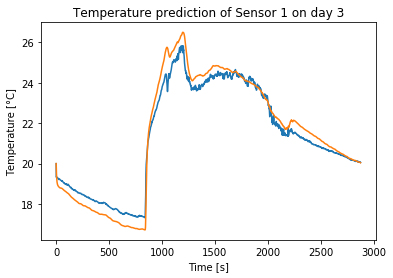

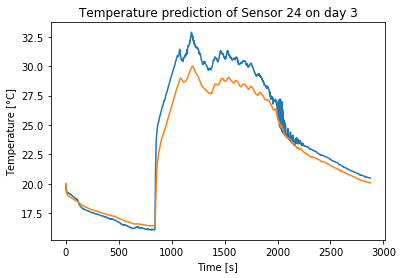

In [55]:
# Plot results

day = 3

yhat_1 = []
ytrue_1 = []
t_1 = []
err2_1 = []

yhat_24 = []
ytrue_24 = []
t_24 = []
err2_24 = []

# state = (alpha, EMA, MSSE, N, err2, y_true, y_time, y_id)
for s in state_global:
    s24 = s[0]
    s1 = s[1]
    ytrue_1.append(s1[1][5])
    yhat_1.append(s1[1][1])
    t_1.append(s1[1][6])
    err2_1.append(s1[1][4])
    
    ytrue_24.append(s24[1][5])
    yhat_24.append(s24[1][1])
    t_24.append(s24[1][6])
    err2_24.append(s24[1][4])

import matplotlib.pyplot as plt


t_1 = np.array(t_1)
yhat_1 = np.array(yhat_1)
ytrue_1 = np.array(ytrue_1)
err2_1 = np.array(err2_1)

print('MSE = ', np.mean(err2_1))
fig1, ax1 = plt.subplots()
ax1.plot(t_1, ytrue_1)
ax1.set_title("Temperature prediction of Sensor %s on day %s" % (1, day))
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlabel("Time [s]")
ax1.plot(t_1, yhat_1)

print('MSE = ', np.mean(err2_24))
fig24, ax24 = plt.subplots()
ax24.plot(t_24, ytrue_24)
ax24.set_title("Temperature prediction of Sensor %s on day %s" % (24, day))
ax24.set_ylabel("Temperature [°C]")
ax24.set_xlabel("Time [s]")
ax24.plot(t_24, yhat_24)

#ax1.plot(t_1, err2_1) 
plt.show()

fig1.savefig('EMA_day%s_sensor%s_%f.png' %(day, 1, np.mean(err2_1)))
fig24.savefig('EMA_day%s_sensor%s_%f.png' %(day, 24, np.mean(err2_24)))

In [31]:
print(ytrue[1][50])
print(ytrue[24][50])

18.1264
18.1264
